In [1]:
### Constants and parameters ###
import sys
import math
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# debug options
debug = True

# Model parameters
mass_wino = 3e3 # wino mass in GeV
mass_diff = 0.16 # mass difference in GeV

# Some numerical constants
Mpc_GeV = 1.5637e38 # Mpc in GeV^-1
pc_GeV = 1e-6*Mpc_GeV
GeV_in_MeV = 1e3
third = 1/3 # one third
kg_in_GeV = 5.60959e26 
gamma_eular = 0.57721 # Eular's constant

# Definition of horizon crossing
crossing = 1 # 2*math.pi

# Physical parameters
fpi = 0.13 # pion decay constant in GeV
gfermi = 1.166378e-5 # Fermi coupling in GeV^-2
vud = 0.97 # 1st diagonal component of the quark mass matrix
mpi = 0.13957 # charged pion mass in GeV
mplanck = 2.435e18 # reduced planck mass in GeV
g_c = 4 # chargino degrees of freedom
g_n = 2 # neutralino degrees of freedom
soundv = math.sqrt(third) # sound speed of relativistic particles
mass_ep = 5.11e-4 # electron mass

# Astrophysical parameters
Msun = 1.9884e30*kg_in_GeV

# Cosmological parameters
#gnow = 2+0.875*(4./11)**(4/3)*3*2
gnow = 2+0.875*(4./11)*3*2
geff = 10.75 # degrees of freedom at the time of interest (before e^± annihilation)
temp_cmb = 2.3482e-13 # CMB temperature in GeV
fnu = 0.875*6/geff # energy fraction of neutrino in the radiation
print(fnu)
rat = ((1+4*fnu/15)/(1+2*fnu/5)/(1+0.128*fnu+0.029*fnu**2))**2
print(rat)
obh2 = 0.0224 # baryon density parameter from Planck 2018
odmh2 = 0.12 # CDM density parameter from Planck 2018
omh2 = odmh2+obh2 # matter density parameter from Planck 2018
rhocrh2 = 8.0992e-47 # critical density divided by h^2 in GeV^4
rhodm0 = rhocrh2*odmh2 # DM density at present
rhom0 = rhocrh2*omh2 # matter density at present
rhor0 = math.pi**2/30*gnow*temp_cmb**4 # radiation density at present
aeq = rhor0/rhom0 # scalefactor at equality
H0h = 2.1332e-42 # H0/h in GeV
redh = 0.674 # reduced Hubble from Planck 2018
As = 2.11e-9 # amplitude of primordial power spectrum at the pivot scale from Planck 2018
ns = 0.965 # spectral index from Planck 2018
kpiv = 0.05/Mpc_GeV # pivot scale

OMatter = (obh2+odmh2)/redh**2
OLambda = 1-OMatter




0.4883720930232558
0.7817050601701054


In [2]:
from scipy import special

### Parameters and functions associated to the background Universe ###
meff = mplanck/math.sqrt(math.pi**2/90*geff)

# Hubble expansion rate in GeV as function of temperature in GeV
def hubble(temp):
    return temp**2/meff

# scale factor as function of temperature in GeV
def scalef(temp):
    return temp_cmb/temp*(gnow/geff)**third

# conformal Hubble expansion rate in GeV as function of temperature in GeV
def chubble(temp):
    return hubble(temp)*scalef(temp)

temp_eq = temp_cmb/aeq
keq = chubble(temp_eq)
tau_eq=crossing/keq
print('temperature at equality [GeV]:',temp_eq)
print('keq [Mpc^{-1}]:',keq*pc_GeV*1e6)


# conformal Hubble expansion rate in GeV as function of temperature in GeV
def tau_to_temp(tau):
    return meff/temp_cmb/tau*(geff/gnow)**third

def num_rel_boson(temp): # number density of massless boson (single dof)
    return temp**3*special.zeta(3)/math.pi**2

def num_rel_fermion(temp): # number density of massless fermion (single dof)
    return 0.75*num_rel_boson(temp)

def num_nonrel(mass,temp):
    return math.exp(-mass/temp)*(mass*temp/2/math.pi)**1.5

temperature at equality [GeV]: 6.926161286244377e-10
keq [Mpc^{-1}]: 0.008094141152092792


In [3]:
### Parameter related to initial and final times of simulation ###
temp_early = 1.e0 # higher temperature in GeV
temp_late = 1.e-6 # lower temperature in GeV
tau_early = 1/chubble(temp_early)
tau_late = 1/chubble(temp_late)
wav_early = crossing/tau_early
wav_late = crossing/tau_late
print(r'# Wave number crossing at the $T_{early}$ [pc^-1]:',wav_early*pc_GeV)
print(r'# Wave number crossing at the $T_{late}$ [pc^-1]:',wav_late*pc_GeV)

# Wave number crossing at the $T_{early}$ [pc^-1]: 11.686330735855186
# Wave number crossing at the $T_{late}$ [pc^-1]: 1.1686330735855183e-05


#Make sure interpolation is accurate enough


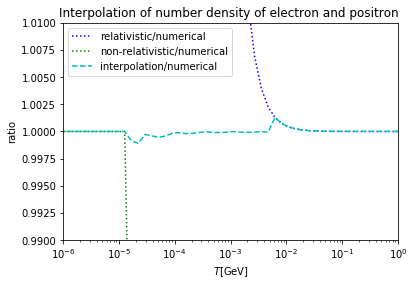

In [4]:
### Electron and positron density ###
from scipy import integrate
from scipy import special
from scipy import interpolate

#baryon to photon ratio
omegabh2 = 0.024
baryo_gamma = 2.75e-10*omegabh2

gep = 2 # degrees of freedom of electron and positron coupled to weak interaction
temp_ep_high = mass_ep*20 # highest temperature of numerical integration
temp_ep_low = mass_ep/75 # lowest temperature of numerical integration
num_temp = 500 # number of bins 

array_temp = np.logspace(math.log10(temp_ep_low),\
                         math.log10(temp_ep_high),num_temp,base=10)
array_nep = np.empty(num_temp)

def nepf(p,temp):
    et = math.sqrt(p**2+mass_ep**2)/temp
    return gep*p**2/math.pi**2/2/(math.exp(et)+1)

for i in range(num_temp):
    temp = array_temp[i]
    pmax = max(20*temp,10*math.sqrt(mass_ep*temp)) # should be modelately large
    array_nep[i] = math.log(integrate.quad(nepf,0,pmax,args=temp,limit=100,maxp1=100,limlst=100)[0])

interp_nep = interpolate.interp1d(array_temp,array_nep)

def get_nep(temp):
    if(temp>=temp_ep_high/2):
        nep = gep*num_rel_fermion(temp)
    elif(temp<=temp_ep_low*2):
        nep = gep*num_nonrel(mass_ep,temp)
    else:
        nep = math.exp(interp_nep(temp))
    return nep+baryo_gamma*2*num_rel_fermion(temp) # including baryon asymmetry

if debug:
    num_temp = 50
    array_temp = np.logspace(math.log10(temp_early),math.log10(temp_late),num_temp,base=10)
    array_nep = np.empty([4,num_temp])

    for i in range(num_temp):
        temp = array_temp[i]
        pmax = max(20*temp,10*math.sqrt(mass_ep*temp))
        array_nep[0,i] = integrate.quad(nepf,0,pmax,args=temp)[0]+baryo_gamma*2*num_rel_fermion(temp)
        array_nep[1,i] = gep*num_rel_fermion(temp)+baryo_gamma*2*num_rel_fermion(temp)
        array_nep[2,i] = gep*num_nonrel(mass_ep,temp)+baryo_gamma*2*num_rel_fermion(temp)
        array_nep[3,i] = get_nep(array_temp[i])

    plt.xscale('log')
    plt.plot(array_temp,array_nep[1,:]/array_nep[0,:],'b:',label='relativistic/numerical')
    plt.plot(array_temp,array_nep[2,:]/array_nep[0,:],'g:',label='non-relativistic/numerical')
    plt.plot(array_temp,array_nep[3,:]/array_nep[0,:],'c--',label='interpolation/numerical')
    plt.axis([temp_late,temp_early,0.99,1.01])
    plt.title('Interpolation of number density of electron and positron ')
    plt.xlabel(r'$T$[GeV]')
    plt.ylabel('ratio')
    plt.legend()
    plt.savefig('figures/test/nep.pdf')
    print('#Make sure interpolation is accurate enough')


In [5]:
### Diffusion of neutrinos
from scipy import integrate
from scipy import special
from scipy import interpolate
from scipy import optimize

# NB. c_nuann, c_nue and c_nunu are fudge factors for nu-e^±, nu-nu couplings; 
# Choose them appropriately 

def coupling_nuann(temp):
    c_nuann = 1
    nnu = 6*num_rel_fermion(temp)
    return c_nuann*(gfermi*temp)**2*nnu

def coupling_nue(temp):
    c_nue = 1
    return c_nue*(gfermi*temp)**2*get_nep(temp)

def coupling_nunu(temp):
    c_nunu = 1
    nnu = 6*num_rel_fermion(temp)
    return c_nunu*(gfermi*temp)**2*nnu

def coupling_nu(temp):
    return coupling_nue(temp)+coupling_nunu(temp)

def ln_gamow_nue(temp):
    return math.log(coupling_nue(temp)/hubble(temp))

def ln_gamow_nunu(temp):
    return math.log(coupling_nunu(temp)/hubble(temp))

def ln_gamow_nu(temp):
    return math.log((coupling_nue(temp)+coupling_nunu(temp))/hubble(temp))

try:
    #temp_nudec = optimize.brentq(ln_gamow_nue,temp_late,temp_early)
    temp_nudec = optimize.brentq(lambda x:ln_gamow_nu(x)-math.log(4),temp_late,temp_early)
    print('#Neutrino decoupling temperature in MeV:',temp_nudec*GeV_in_MeV)
    tau_nudec = 1/chubble(temp_nudec)
    wav_nudec = crossing/tau_nudec
    print(r'#Wave number crossing at the neutrino decoupling [pc^-1]:',wav_nudec*pc_GeV)
except:
    print('#Error: neutrino decoupling is not found; change temp_early or temp_late')
    sys.exit()

def dampfunc(tau):
    # Derivative of the neutrino diffusion factor $(k_{nu,dec}/k_D^2)$ wrt conformal time
    temp = tau_to_temp(tau)
    hub = hubble(temp)
    a = scalef(temp)

    t_nu = 1/(coupling_nue(temp)+coupling_nunu(temp)) 
    vis = 4*fnu/15*t_nu # NB. this is not valid after neutrino decoupling
    return 0.5/a*vis*wav_nudec**2
    
def calc_diffscale(tau):
    taumin = tau*0.01 # early enough
    x = integrate.quad(dampfunc,taumin,tau,limit=100,maxp1=100,limlst=100)[0]
    return wav_nudec/math.sqrt(x)

# lookup table for the diffusion scale
num_temp = 100
array_temp = np.logspace(math.log10(temp_early*1.1),\
                         math.log10(temp_late*0.9),num_temp,base=10) # margin
array_diffscale = np.empty(num_temp)
for i in range(num_temp):
    tau = 1/chubble(array_temp[i])
    array_diffscale[i] = calc_diffscale(tau)

interp_diffscale = interpolate.interp1d(array_temp,array_diffscale)

def get_wav_diff(temp):
    if(temp>temp_early):
        return np.inf
    if(temp<temp_late):
        return interp_diffscale(temp_nudec)
    else:
        return interp_diffscale(temp)


#print(r'# Diffusion wave number at the $T_{early}$ [pc^-1]:',
#      get_wav_diff(temp_early)*pc_GeV)
#print(r'# Diffusion wave number at the $T_{late}$ [pc^-1]:',
#      get_wav_diff(temp_late)*pc_GeV)



#Neutrino decoupling temperature in MeV: 2.619444134815923
#Wave number crossing at the neutrino decoupling [pc^-1]: 0.030611690503554913


/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


In [6]:
#### coupling of neutralino
from scipy.optimize import brentq

# decay rate of chargino
def rate_decay(): # in GeV
    return fpi**2*gfermi**2*vud**2/math.pi\
        *mass_diff**3*math.sqrt(1-mpi**2/mass_diff**2)

# inelastic scattering rate of wino in plasma
def rate_inela(temp): # in GeV as function of temperature in GeV
    return 16/math.pi**3*gfermi**2*temp**3\
    *(mass_diff**2+6*mass_diff*temp+12*temp**2)

def ln_gamow_chi(temp):
    x = rate_decay()+rate_inela(temp)
    x *= g_c/hubble(temp)
    x *= math.exp(-mass_diff/temp)
    x = max(1e-30,x)
    return math.log(x)

#def ln_gamow_chi_dec(temp):
#    return ln_gamow_chi(temp)-math.log(4) 

temp_dec = brentq(lambda x:ln_gamow_chi(x)-math.log(4),temp_late,temp_early)
# factor 4 from Bertschinger
print(r'#Decoupling temperature of neutralino [MeV]:',"{:f}".format(temp_dec*GeV_in_MeV))

# reference scales at kinetic decoupling
tau_dec = 1/chubble(temp_dec)
wav_dec = crossing/tau_dec #/soundv # (not sound) horizon crossing 
print ('#Wave number crossing the sound horizon at decoupling [pc^-1]:',\
       "{:f}".format(wav_dec*pc_GeV))



#Decoupling temperature of neutralino [MeV]: 9.185666
#Wave number crossing the sound horizon at decoupling [pc^-1]: 0.107347


#Wave number of nu diffusion at nu decoupling [pc^{-1}] 0.5412818409549881


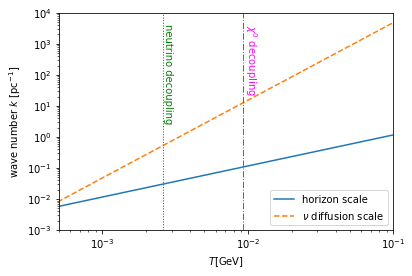

In [9]:
wav_nudiff = get_wav_diff(temp_nudec)
print('#Wave number of nu diffusion at nu decoupling [pc^{-1}]',wav_nudiff*pc_GeV)

if(debug):
    array_diffscale = np.empty(num_temp)
    array_horizon = np.empty(num_temp)

    for i in range(num_temp):
        temp = array_temp[i]
        array_diffscale[i] = get_wav_diff(temp)
        array_horizon[i] = crossing*chubble(temp)

    plt.xscale('log')
    plt.yscale('log')
    plt.plot(array_temp,array_horizon*pc_GeV,'-',label='horizon scale')
    plt.plot(array_temp,array_diffscale*pc_GeV,'--',label=r'$\nu$ diffusion scale')

    #plt.title(r'Scales')
    plt.axvline(x=temp_nudec,c='g',ls=':',lw=1)
    plt.text(temp_nudec,.3e1,'neutrino decoupling',rotation=-90,color='green')
    plt.axvline(x=temp_dec,c='magenta',ls='-.',lw=1)
    plt.text(temp_dec,.3e2,r'$\chi^0$ decoupling',rotation=-90,color='magenta')
    #plt.axis([temp_late,temp_early,None,None])
    plt.axis([.5e-3,1e-1,1e-3,1e4])
    plt.xlabel(r'$T$[GeV]')
    plt.ylabel(r'wave number $k$ [pc$^{-1}$]')
    plt.legend()
    plt.savefig("figures/test/scales.pdf")

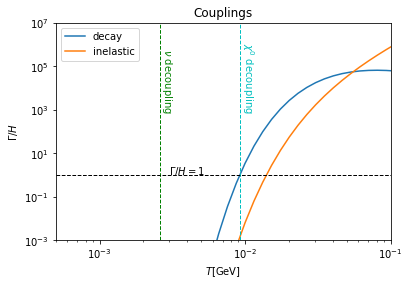

In [15]:
if(debug):
    num_temp = 100
    array_temp = np.logspace(math.log10(temp_late),\
                         math.log10(temp_early),num_temp,base=10)
    array_decay = np.empty(num_temp)
    array_inela = np.empty(num_temp)

    for i in range(num_temp):
        temp = array_temp[i]
        array_decay[i] = rate_decay()*math.exp(-mass_diff/temp)/hubble(temp)
        array_inela[i] = rate_inela(temp)*math.exp(-mass_diff/temp)/hubble(temp)

    plt.xscale('log')
    plt.yscale('log')
    plt.plot(array_temp,array_decay,label='decay')
    plt.plot(array_temp,array_inela,label='inelastic')
    plt.axvline(x=temp_nudec,c='g',ls='--',lw=1)
    plt.text(temp_nudec,1e3,r'$\nu$ decoupling',rotation=-90,color='green')
    plt.axvline(x=temp_dec,c='c',ls='--',lw=1)
    plt.text(temp_dec,1e3,r'$\chi^0$ decoupling',rotation=-90,color='c')
    plt.axhline(y=1,c='black',ls='--',lw=1)
    plt.text(3e-3,1,r'$\Gamma/H=1$',color='black')
    plt.title(r'Couplings')
    plt.xlabel(r'$T$[GeV]')
    plt.ylabel(r'$\Gamma/H$')
    plt.axis([.5e-3,1e-1,1e-3,1e7])
    #plt.axis([temp_late,temp_early,1e-3,1e6])
    plt.legend()
    plt.savefig('figures/test/couplings.pdf')

norm[pc^{-1}], tau_*[pc], dtau [pc]: 1.073467301294747 9.315607459993092 0.9315607459993092
norm[pc^{-1}], tau_*[pc], dtau [pc]: 0.6457230708707868 8.65643458271783 0.5836828293038442


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


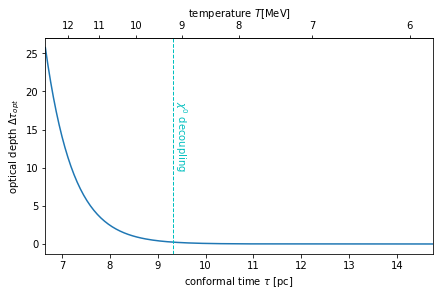

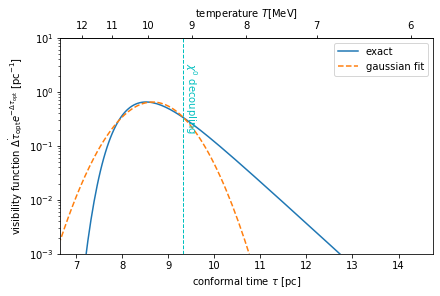

In [84]:
# optical depth & visibility function
from scipy.optimize import curve_fit

num_temp = 200
array_temp = np.linspace(temp_dec*0.25,temp_dec*1.4,num_temp)
array_ctime = np.array([1/chubble(temp) for temp in array_temp])
array_depth = np.empty(num_temp)
array_visib = np.empty(num_temp)

def ddepth_dtemp(temp):
    return np.exp(ln_gamow_chi(temp))/temp

array_depth[0]=0
array_visib[0]=0
for i in range(1,num_temp):
    temp1 = array_temp[i-1]
    temp2 = array_temp[i]
    ddepth = integrate.quad(ddepth_dtemp,temp1,temp2,limit=100,maxp1=100,limlst=100)[0]
    array_depth[i] = ddepth+array_depth[i-1]
    array_visib[i] = np.exp(-array_depth[i]+ln_gamow_chi(temp2))/array_ctime[i]

# Gaussian fitting of visibility function
def gaussian_func(x, A, mu, sigma):
    return A*np.exp( -0.5*((x - mu)/sigma)**2)
# initial guess of parameters Gaussian fitting
dlntau = 0.1
dtau = dlntau*tau_dec
fit_visib_init = np.array([1/dtau, tau_dec, dtau])
print('norm[pc^{-1}], tau_*[pc], dtau [pc]:',fit_visib_init[0]*pc_GeV,fit_visib_init[1]/pc_GeV,fit_visib_init[2]/pc_GeV)
# estimate optimal parameter & parameter covariance
fit_visib_opt, fit_visib_cov = curve_fit(gaussian_func, array_ctime, array_visib, p0=fit_visib_init)
array_visib_fit = gaussian_func(array_ctime, fit_visib_opt[0], fit_visib_opt[1], fit_visib_opt[2])
print('norm[pc^{-1}], tau_*[pc], dtau [pc]:',fit_visib_opt[0]*pc_GeV,fit_visib_opt[1]/pc_GeV,fit_visib_opt[2]/pc_GeV)

# correspondence of tau[pc] to temp[MeV] for plotting
def tau_pc_to_temp_MeV(tau_pc):
    return tau_to_temp(tau_pc*pc_GeV)*GeV_in_MeV
def temp_MeV_to_tau_pc(temp_MeV):
    return 1/chubble(temp_MeV/GeV_in_MeV)/pc_GeV

fig,ax1 = plt.subplots(constrained_layout=True)
ax1.set_xlabel(r'conformal time $\tau$ [pc] ')
ax1.set_ylabel(r'optical depth $\Delta\tau_{opt}$')
ax1.set_xlim(array_ctime[num_temp-1]/pc_GeV,array_ctime[num_temp//3]/pc_GeV)
ax2 = ax1.secondary_xaxis('top', functions=(tau_pc_to_temp_MeV,temp_MeV_to_tau_pc))
ax2.set_xlabel(r'temperature $T$[MeV]')
ax1.plot(array_ctime/pc_GeV,array_depth)
ax1.axvline(x=tau_dec/pc_GeV,c='c',ls='--',lw=1)
ax1.text(tau_dec/pc_GeV,10,r'$\chi^0$ decoupling',rotation=-90,color='c')
ax1.plot
plt.savefig('figures/test/optical_depth.pdf')

fig,ax1 = plt.subplots(constrained_layout=True)
ax1.set_yscale('log')
ax1.set_ylim(1e-3,10)
ax1.set_xlabel(r'conformal time $\tau$ [pc] ')
ax1.set_ylabel(r'visibility function $\dot{\Delta \tau}_{\rm opt}e^{-\Delta\tau_{\rm opt}}$ [pc$^{-1}$]')
ax1.set_xlim(array_ctime[num_temp-1]/pc_GeV,array_ctime[num_temp//3]/pc_GeV)
ax2 = ax1.secondary_xaxis('top', functions=(tau_pc_to_temp_MeV,temp_MeV_to_tau_pc))
ax2.set_xlabel(r'temperature $T$[MeV]')
ax1.plot(array_ctime/pc_GeV,array_visib*pc_GeV,label='exact')
ax1.plot(array_ctime/pc_GeV,array_visib_fit*pc_GeV,'--',label='gaussian fit')
ax1.axvline(x=tau_dec/pc_GeV,c='c',ls='--',lw=1)
ax1.text(tau_dec/pc_GeV,0.2,r'$\chi^0$ decoupling',rotation=-90,color='c')
plt.legend()
plt.savefig('figures/test/visibility.pdf')

# def func_pratio_fit(wav,fit_visib):
#     amp = fit_visib[0]*fit_visib[2]*np.sqrt(math.pi/2)
#     x0 = wav*fit_visib[1]/np.sqrt(3)
#     dx = wav*fit_visib[2]/np.sqrt(3)
#     return (1+amp*(np.exp(-dx**2/2)*((2+dx**2)*np.cos(x0)+x0*np.sin(x0))-2))**2

# num_wav = 500
# arr_wav = np.logspace(np.log10(wav_dec*0.5),np.log10(wav_dec*100),num_wav,base=10)
# arr_atheta = np.array([func_pratio_fit(wav,fit_visib_opt) for wav in arr_wav])
# plt.figure()
# plt.xscale('log')
# plt.xlim(0.08,20)
# #plt.ylim(None,12.5)
# plt.plot(arr_wav*pc_GeV,arr_atheta)
# plt.axvline(x=wav_dec*pc_GeV,c='c',ls='--',lw=1)
# plt.text(wav_dec*pc_GeV,5,r'$k_{\rm kd}$',rotation=-90,color='c')
# plt.xlabel(r'wave number k [pc$^{-1}$]')
# plt.ylabel(r'ratio of power spectra $\delta_{\chi^0}^2/\delta_c^2$')
# plt.show()

In [23]:
### Perturbation equations and initial solution
from scipy import special

idx_eta = 0
idx_hdot = idx_eta+1 # for consistency check
idx_etadot = idx_hdot+1 # for consistency check
idx_delta_cdm = idx_etadot+1
#
idx_delta_chi = idx_delta_cdm+1
idx_delta_chi_nonconserve = idx_delta_chi+1
idx_theta_chi = idx_delta_chi_nonconserve+1
idx_delta_chi_wo_diff = idx_theta_chi+1
idx_theta_chi_wo_diff = idx_delta_chi_wo_diff+1
#
idx_delta_gamma = idx_theta_chi_wo_diff+1
idx_theta_gamma = idx_delta_gamma+1
idx_delta_nu = idx_theta_gamma+1
idx_theta_nu = idx_delta_nu+1
lmax_nu = 100 # must be >= 3
num_pert = idx_theta_nu+lmax_nu

ell = np.arange(-idx_delta_nu,lmax_nu+1)
print(r'l_max:',ell[num_pert-1])

def hddot(wav,tau,y):
    pi_tot = (1-fnu)*y[idx_delta_gamma]+fnu*y[idx_delta_nu]
    pi_tot *= 3*soundv**2
    dh = hdot(wav,tau,y)
    return -2*dh/tau+2*wav**2*y[idx_eta]-3*pi_tot/tau**2

def etaddot(wav,tau,y):
    sigma_tot = fnu*y[idx_theta_nu+1]/2
    dh = hdot(wav,tau,y)
    ddh = hddot(wav,tau,y)
    deta = etadot(wav,tau,y)
    return -ddh/6-(dh+6*deta)/3/tau+wav**2*y[idx_eta]/3-2*sigma_tot/tau**2

def hdot(wav,tau,y):
    delta_tot = (1-fnu)*y[idx_delta_gamma]+fnu*y[idx_delta_nu]
    return 2*tau*wav**2*y[idx_eta]+3*delta_tot/tau

def etadot(wav,tau,y):
    theta_tot = (1-fnu)*y[idx_theta_gamma]+fnu*y[idx_theta_nu]
    return 2*theta_tot/(tau*wav)**2
    
def pert_eq(wav,tau,y):
    temp = tau_to_temp(tau)
    a = scalef(temp)

    dh = hdot(wav,tau,y)
    deta = etadot(wav,tau,y)
    
    tight_nu = tau<tau_nudec/10 and wav < get_wav_diff(temp)/10
    tight_chi = tau<tau_dec/1.5
    
    dy = np.zeros(num_pert)
    dy[idx_eta] = deta
    dy[idx_hdot] = hddot(wav,tau,y)
    dy[idx_etadot] = etaddot(wav,tau,y)
    dy[idx_delta_cdm] = -dh/2
    dy[idx_delta_gamma] = -4/3*y[idx_theta_gamma]-2/3*dh \
        -a*coupling_nu(temp)*fnu/(1-fnu)*(y[idx_delta_gamma]-y[idx_delta_nu])
    dy[idx_theta_gamma] = wav**2*y[idx_delta_gamma]/4 \
        -a*coupling_nu(temp)*fnu/(1-fnu)*(y[idx_theta_gamma]-y[idx_theta_nu])
    dy[idx_delta_nu] = -4/3*y[idx_theta_nu]-2/3*dh \
        -a*coupling_nu(temp)*(y[idx_delta_nu]-y[idx_delta_gamma])
    dy[idx_theta_nu] = wav**2*(y[idx_delta_nu]/4-y[idx_theta_nu+1]/2) \
        -a*coupling_nu(temp)*(y[idx_theta_nu]-y[idx_theta_gamma])
    if(not tight_nu): 
        dy[idx_theta_nu+1] = 8*y[idx_theta_nu]/15-3*wav*y[idx_theta_nu+2]/5+4*dh/15+8*deta/5 \
            -a*coupling_nu(temp)*y[idx_theta_nu+1]
        dy[idx_theta_nu+2:num_pert-1] = wav/(2*ell[idx_theta_nu+2:num_pert-1]+1)\
            *(ell[idx_theta_nu+2:num_pert-1]*y[idx_theta_nu+1:num_pert-2]\
              -ell[idx_theta_nu+3:num_pert]*y[idx_theta_nu+3:num_pert])\
            -a*coupling_nu(temp)*y[idx_theta_nu+2:num_pert-1]
        dy[num_pert-1] = wav*y[num_pert-2]-((2*ell[num_pert-1]+1)/tau \
            +a*coupling_nu(temp))*y[num_pert-1] # relaxation time approximation

    #else: 
        # nothing to do at the zeroth order in tight coupling
    
    dy[idx_delta_chi_nonconserve] = -y[idx_theta_chi]-dh/2 # number is not conserved
    ratio_chi = g_c/g_n*math.exp(-mass_diff/temp)
    dy[idx_delta_chi] = -y[idx_theta_chi]-ratio_chi*\
        (y[idx_theta_gamma]+mass_diff/temp/4*(y[idx_delta_gamma]/tau+dy[idx_delta_gamma]))\
        -ratio_chi/(1+ratio_chi)*(mass_diff/temp)**2*y[idx_delta_gamma]/4/tau
    dy[idx_delta_chi] = dy[idx_delta_chi]/(1+ratio_chi)-dh/2 # number conservation
    
    if(tight_chi):
        dy[idx_theta_chi] = dy[idx_theta_gamma]
    else:
        dy[idx_theta_chi] = -y[idx_theta_chi]/tau\
            +math.exp(ln_gamow_chi(temp))/tau*(y[idx_theta_gamma]-y[idx_theta_chi])
    #
    dy[idx_delta_chi_wo_diff] = -y[idx_theta_chi_wo_diff]-hdot(wav,tau,ideal(wav,tau))/2
    if(tight_chi):
        dy[idx_theta_chi_wo_diff] = wav**2*ideal(wav,tau)[idx_delta_gamma]/4
    else:
        dy[idx_theta_chi_wo_diff] = -y[idx_theta_chi_wo_diff]/tau\
            +math.exp(ln_gamow_chi(temp))/tau*\
            (ideal(wav,tau)[idx_theta_gamma]-y[idx_theta_chi_wo_diff])
    #
    return dy

def ideal(wav,tau):
    y = np.zeros(num_pert)
    x = tau*wav*soundv
    c = math.cos(x)
    s = math.sin(x)
    ci = special.sici(x)[1]
    y[idx_eta] = 4*(1-c)/x**2
    y[idx_hdot] = 24*(2*(1-c)/x**3+1/x-2*s/x**2)*wav*soundv
    y[idx_etadot] = 4*(-2*(1-c)/x**3+s/x**2)*wav*soundv
    y[idx_delta_cdm] = 12*((1-c)/x**2+ci-math.log(x)-s/x)
    y[idx_delta_gamma] = 8*(2+(x**2-2)*c-2*x*s)/x**2
    y[idx_theta_gamma] = -8*(2/x-2*c/x-s)*wav/4/soundv
    y[idx_delta_nu] = y[idx_delta_gamma]
    y[idx_theta_nu] = y[idx_theta_gamma]
    #
    y[idx_delta_chi] = 12/x**2+6*c-12*c/x**2-12*s/x
    y[idx_delta_chi_nonconserve] = y[idx_delta_chi]
    y[idx_theta_chi] = y[idx_theta_gamma]
    y[idx_delta_chi_wo_diff] = y[idx_delta_chi]
    y[idx_theta_chi_wo_diff] = y[idx_theta_chi]
    #
    return y

l_max: 100


In [24]:
#%%timeit

### Perturbation evolution at single wave number
wav = wav_dec*30
wav_suffix = '30'
tau_hc = crossing/wav
print('#Wave number [pc^{-1}]:',"{:f}".format(wav*pc_GeV))

# diffusion crossing time used for neutrino tight coupling criteria
def ln_dampfactor(temp,wav):
    return math.log(wav**2/get_wav_diff(temp)**2)
def get_tau_diff(wav):
    try:
        temp_diff = optimize.brentq(ln_dampfactor,temp_early,temp_late,args=(wav))
        print('#Diffusion crossing temperature [MeV]:',"{:f}".format(temp_diff*GeV_in_MeV))
        tau_diff = 1/chubble(temp_diff)
        print('#Diffusion time in pc',tau_diff/pc_GeV)
    except:
        temp_diff = -1 # no diffusion crossing
        print('#No diffusion crossing')
        tau_diff = -1/chubble(temp_diff)
    return tau_diff

###
def get_tau_ini(wav): # 
    tau_ini = crossing/wav*0.1
    if(tau_ini<tau_early): print('WARNING: tau_early is too large')
    tau_ini = max(tau_early,tau_ini)
    return tau_ini
def get_tau_fin(wav): # deep in horizon and diffusion scales
    tau_diff = get_tau_diff(wav)
    tau_fin = max(crossing/wav*1000,tau_diff*20,tau_dec*5)
    if(tau_fin>tau_late): print('WARNING: tau_late is too small')
    tau_fin = min(tau_late,tau_fin)
    return tau_fin
tau_ini = get_tau_ini(wav)
tau_fin = get_tau_fin(wav)
tau_diff = get_tau_diff(wav)
###

num_tau = 3000
array_tau = np.linspace(tau_ini,tau_fin,num_tau)
dtau = (tau_fin-tau_ini)/num_tau

y = np.empty(num_pert)
y = ideal(wav,tau_ini) # initial condition

# wrapper of pert_eq for solve_ivp
def deriv(tau,y):
    return pert_eq(wav,tau,y)

# integration
sol = solve_ivp(deriv,[tau_ini,tau_fin],y,t_eval=array_tau)
print ("#Done")

array_hdot0 = np.empty(num_tau)
for i in range(num_tau):
    array_hdot0[i] = hdot(wav,array_tau[i],ideal(wav,array_tau[i]))

array_hdot = np.empty(num_tau)
for i in range(num_tau):
    array_hdot[i] = hdot(wav,array_tau[i],sol.y[:,i])

array_etadot = np.empty(num_tau)
for i in range(num_tau):
    array_etadot[i] = etadot(wav,array_tau[i],sol.y[:,i])

array_delta_cdm0 = np.empty(num_tau)
for i in range(num_tau):
    array_delta_cdm0[i] = ideal(wav,array_tau[i])[idx_delta_cdm]



#Wave number [pc^{-1}]: 3.220402
#Diffusion crossing temperature [MeV]: 5.343607
#Diffusion time in pc 16.01353857116401
#Diffusion crossing temperature [MeV]: 5.343607
#Diffusion time in pc 16.01353857116401
#Done


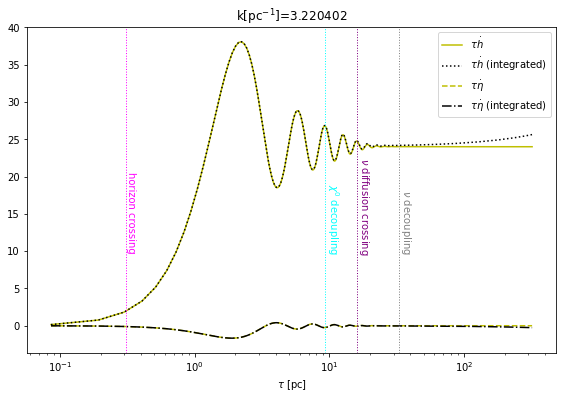

In [25]:
### consistency check via hdot and etadot
yoffset=10
plt.figure(figsize=(14, 6))
plt.subplots_adjust(right=0.65)
plt.xscale('log')
#plt.yscale('log')

plt.plot(array_tau/pc_GeV,array_hdot[:]*array_tau,'y-',label=r'$\tau\dot h$')
plt.plot(array_tau/pc_GeV,sol.y[idx_hdot,:]*array_tau,'k:',label=r'$\tau\dot h$ (integrated)')
plt.plot(array_tau/pc_GeV,array_etadot[:]*array_tau,'y--',label=r'$\tau\dot\eta$')
plt.plot(array_tau/pc_GeV,sol.y[idx_etadot,:]*array_tau,'k-.',label=r'$\tau\dot\eta$ (integrated)')

plt.axvline(x=tau_hc/pc_GeV,c='magenta',ls=':',lw=1)
plt.text(tau_hc/pc_GeV,yoffset,'horizon crossing',rotation=-90,color='magenta')
plt.axvline(x=tau_dec/pc_GeV,c='cyan',ls=':',lw=1)
plt.text(tau_dec/pc_GeV,yoffset,r'$\chi^0$ decoupling',rotation=-90,color='cyan')
if(tau_diff>0):
    plt.axvline(x=tau_diff/pc_GeV,c='purple',ls=':',lw=1)
    plt.text(tau_diff/pc_GeV,yoffset,r'$\nu$ diffusion crossing',rotation=-90,color='purple')
plt.axvline(x=tau_nudec/pc_GeV,c='gray',ls=':',lw=1)
plt.text(tau_nudec/pc_GeV,yoffset,r'$\nu$ decoupling',rotation=-90,color='gray')
plt.xlabel(r'$\tau$ [pc]')
plt.title(r'k[pc$^{-1}$]='+"{:f}".format(wav*pc_GeV))

#plt.legend(bbox_to_anchor=(1.5, .5),loc=5,ncol=1,borderaxespad=0.)
plt.legend()
plt.savefig('figures/test/consistency_wav'+wav_suffix+'.pdf')

paramater w/o nudiff: [-11.99902538  -7.44797083]
paramater w/ nudiff: [-12.00105406  -7.43468354]
ratio at a_eq: 0.9998939082498134
paramater for cdm w/o nudiff: [-11.99902538  -7.44797083]
paramater for chi w/o nudiff: [ 27.24859153 -67.56616638]
ratio at a_eq: -0.5248761448087587
paramater for cdm w/ nudiff: [-12.00105406  -7.43468354]
paramater for chi w/ nudiff: [ 26.08555608 -63.32013238]
ratio at a_eq: -0.5465691712960343


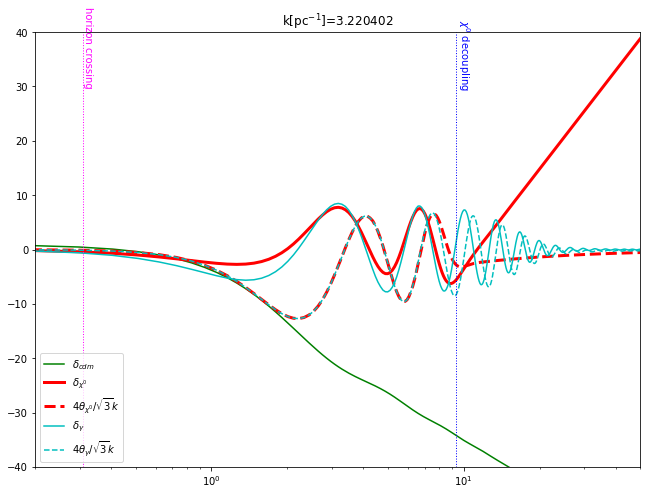

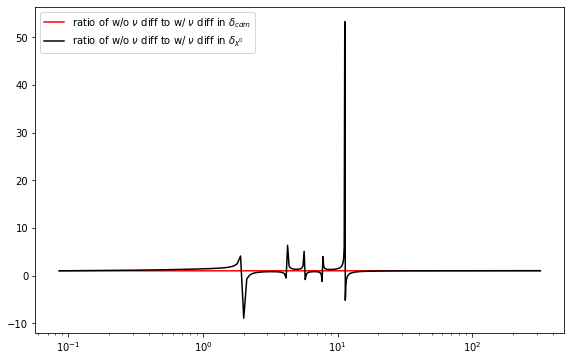

In [26]:
yoffset=30
#plt.rcParams["font.size"] = 20
plt.figure(figsize=(16, 8))
plt.subplots_adjust(right=0.65)
plt.xscale('log')
#plt.yscale('log')
#plt.plot(array_tau/pc_GeV,sol.y[idx_eta,:],'c-',label=r'$\eta$')
#plt.plot(array_tau/pc_GeV,array_hdot[:]*array_tau,'y-',label=r'$\tau\dot h$')
#plt.plot(array_tau/pc_GeV,array_hdot0[:]*array_tau,'y:',label=r'analytic $\tau\dot h$ w/o $\nu$ diffusion')
plt.plot(array_tau/pc_GeV,sol.y[idx_delta_cdm,:],'g-',label=r'$\delta_{cdm}$')
#plt.plot(array_tau/pc_GeV,array_delta_cdm0[:],'r:',label=r'analytic $\delta_{cdm}$ w/o $\nu$ diffusion')
#
plt.plot(array_tau/pc_GeV,sol.y[idx_delta_chi,:],'r-',label=r'$\delta_{\chi^0}$',linewidth = 3.0)
plt.plot(array_tau/pc_GeV,sol.y[idx_theta_chi,:]*4*soundv/wav,'r--',label=r'$4\theta_{\chi^0}/\sqrt{3}k$',linewidth = 3.0)
#plt.plot(array_tau/pc_GeV,sol.y[idx_delta_chi_nonconserve,:],'m--',label=r'$\delta_{\chi^0}$ w/o ${\chi}$ number conservation')
#plt.plot(array_tau/pc_GeV,sol.y[idx_delta_chi_wo_diff,:],'m:',label=r'analytic $\delta_{\chi^0}$ w/o $\nu$ diffusion')
#plt.plot(array_tau/pc_GeV,sol.y[idx_theta_chi_wo_diff,:]*4*soundv/wav,'m-.',label=r'analytic $\theta_{\chi^0}$ w/o $\nu$ diffusion')
#
plt.plot(array_tau/pc_GeV,sol.y[idx_delta_gamma,:],'c-',label=r'$\delta_\gamma$')
plt.plot(array_tau/pc_GeV,sol.y[idx_theta_gamma,:]*4*soundv/wav,'c--',label=r'$4\theta_\gamma /\sqrt{3}k$')
#plt.plot(array_tau/pc_GeV,sol.y[idx_delta_nu,:],'b-',label=r'$\delta_\nu$')
#plt.plot(array_tau/pc_GeV,sol.y[idx_theta_nu,:]*4*soundv/wav,'b--',label=r'$4\theta_\nu /\sqrt{3}k$')
#plt.plot(array_tau/pc_GeV,sol.y[idx_theta_nu+1,:]/2,'b-.',label=r'$\sigma_\nu$')

plt.axvline(x=tau_hc/pc_GeV,c='magenta',ls=':',lw=1)
plt.text(tau_hc/pc_GeV,yoffset,'horizon crossing',rotation=-90,color='magenta')
plt.axvline(x=tau_dec/pc_GeV,c='blue',ls=':',lw=1)
plt.text(tau_dec/pc_GeV,yoffset,r'$\chi^0$ decoupling',rotation=-90,color='blue')
#if(tau_diff>0):
#    plt.axvline(x=tau_diff/pc_GeV,c='purple',ls=':',lw=1)
#    plt.text(tau_diff/pc_GeV,yoffset,r'$\nu$ diffusion crossing',rotation=-90,color='purple')
#plt.axvline(x=tau_nudec/pc_GeV,c='gray',ls=':',lw=1)
#plt.text(tau_nudec/pc_GeV,yoffset,r'$\nu$ decoupling',rotation=-90,color='gray')
#plt.xlabel(r'$\tau$ [pc]')
plt.title(r'k[pc$^{-1}$]='+"{:f}".format(wav*pc_GeV))

#plt.legend(bbox_to_anchor=(1.5, .5),loc=5,ncol=1,borderaxespad=0.)
plt.legend(loc='lower left')
##
plt.xlim([0.2,50])
plt.ylim([-40,40])
##
plt.savefig('figures/test/pert_wav'+wav_suffix+'.pdf')


plt.figure(figsize=(14, 6))
plt.subplots_adjust(right=0.65)
plt.xscale('log')
#plt.plot(array_tau/pc_GeV,sol.y[idx_eta,:]*array_tau[:]**2,'c-',label=r'$\eta$')
plt.plot(array_tau/pc_GeV,array_delta_cdm0[:]/sol.y[idx_delta_cdm,:],'r-',label=r'ratio of w/o $\nu$ diff to w/ $\nu$ diff in $\delta_{cdm}$')
#plt.plot(array_tau/pc_GeV,sol.y[idx_delta_cdm,:],'r-',label=r'$\delta_{cdm}$')
#plt.plot(array_tau/pc_GeV,array_delta_cdm0[:],'r:',label=r'analytic $\delta_{cdm}$ w/o $\nu$ diffusion')
#
plt.plot(array_tau/pc_GeV,sol.y[idx_delta_chi_wo_diff,:]/sol.y[idx_delta_chi,:],'k-',label=r'ratio of w/o $\nu$ diff to w/ $\nu$ diff in $\delta_{\chi^0}$')
#plt.plot(array_tau/pc_GeV,sol.y[idx_delta_chi,:],'k-',label=r'$\delta_{\chi^0}$')
#plt.plot(array_tau/pc_GeV,sol.y[idx_delta_chi_nonconserve,:],'m--',label=r'$\delta_{\chi^0}$ w/o ${\chi}$ number conservation')
#plt.plot(array_tau/pc_GeV,sol.y[idx_delta_chi_wo_diff,:],'m:',label=r'analytic $\delta_{\chi^0}$ w/o $\nu$ diffusion')
#plt.plot(array_tau/pc_GeV,sol.y[idx_theta_chi,:]*4*soundv/wav,'k--',label=r'$\theta_{\chi^0}$')
#plt.plot(array_tau/pc_GeV,sol.y[idx_theta_chi_wo_diff,:]*4*soundv/wav,'m-.',label=r'analytic $\theta_{\chi^0}$ w/o $\nu$ diffusion')
#

#plt.axvline(x=tau_hc/pc_GeV,c='magenta',ls=':',lw=1)
#plt.text(tau_hc/pc_GeV,yoffset,'horizon crossing',rotation=-90,color='magenta')
#plt.axvline(x=tau_dec/pc_GeV,c='cyan',ls=':',lw=1)
#plt.text(tau_dec/pc_GeV,yoffset,r'$\chi^0$ decoupling',rotation=-90,color='cyan')
#if(tau_diff>0):
#    plt.axvline(x=tau_diff/pc_GeV,c='purple',ls=':',lw=1)
#    plt.text(tau_diff/pc_GeV,yoffset,r'$\nu$ diffusion crossing',rotation=-90,color='purple')
#plt.axvline(x=tau_nudec/pc_GeV,c='gray',ls=':',lw=1)
#plt.text(tau_nudec/pc_GeV,yoffset,r'$\nu$ decoupling',rotation=-90,color='gray')
#plt.xlabel(r'$\tau$ [pc]')
#plt.title(r'k[pc$^{-1}$]='+"{:f}".format(wav*pc_GeV))

#plt.legend(bbox_to_anchor=(1.5, .5),loc=5,ncol=1,borderaxespad=0.)
plt.legend()
plt.savefig('figures/test/pert_wav'+wav_suffix+'_ext.pdf')

from scipy import optimize

def fit_delta(x,a,b):
    return a*np.log(x)+b
param1,covariance1 = optimize.curve_fit(fit_delta,array_tau[-100:-1]/pc_GeV,array_delta_cdm0[-100:-1],p0=[array_delta_cdm0[-1],0])
param2,covariance2 = optimize.curve_fit(fit_delta,array_tau[-100:-1]/pc_GeV,sol.y[idx_delta_cdm,-100:-1],p0=[sol.y[idx_delta_cdm,-1],0])
print('paramater w/o nudiff:', param1)
print('paramater w/ nudiff:', param2)
print('ratio at a_eq:',fit_delta(tau_eq/pc_GeV,param1[0],param1[1])/
     fit_delta(tau_eq/pc_GeV,param2[0],param2[1]))

param1,covariance1 = optimize.curve_fit(fit_delta,array_tau[-100:-1]/pc_GeV,array_delta_cdm0[-100:-1],p0=[array_delta_cdm0[-1],0])
param2,covariance2 = optimize.curve_fit(fit_delta,array_tau[-100:-1]/pc_GeV,sol.y[idx_delta_chi_wo_diff,-100:-1],p0=[sol.y[idx_delta_chi_wo_diff,-1],0])
print('paramater for cdm w/o nudiff:', param1)
print('paramater for chi w/o nudiff:', param2)
print('ratio at a_eq:',fit_delta(tau_eq/pc_GeV,param1[0],param1[1])/
     fit_delta(tau_eq/pc_GeV,param2[0],param2[1]))

param1,covariance1 = optimize.curve_fit(fit_delta,array_tau[-100:-1]/pc_GeV,sol.y[idx_delta_cdm,-100:-1],p0=[sol.y[idx_delta_cdm,-1],0])
param2,covariance2 = optimize.curve_fit(fit_delta,array_tau[-100:-1]/pc_GeV,sol.y[idx_delta_chi,-100:-1],p0=[sol.y[idx_delta_chi,-1],0])
print('paramater for cdm w/ nudiff:', param1)
print('paramater for chi w/ nudiff:', param2)
print('ratio at a_eq:',fit_delta(tau_eq/pc_GeV,param1[0],param1[1])/
     fit_delta(tau_eq/pc_GeV,param2[0],param2[1]))

In [37]:
##### power spectrum
###
#num_wav = 500
#wav_high = wav_dec*100
#wav_low = wav_dec*0.03
num_wav = 500
wav_high = wav_dec*100
wav_low = wav_dec*0.1
###
array_wav = np.logspace(math.log10(wav_low),math.log10(wav_high),num_wav,base=10)
#array_wav = np.linspace(wav_low,wav_high,num_wav)

# number of output
num_tau = 300

array_tau_fin = np.empty(num_wav)
array_ratio_cdm = np.empty(num_wav)
array_ratio_wo_diff = np.empty(num_wav)
array_ratio_w_diff = np.empty(num_wav)

array_sol = np.empty([num_wav,num_pert,num_tau])
for i in range(num_wav):
    wav = array_wav[i]
    print('wave number in pc^{-1}:',pc_GeV*wav)
    
    # initial condition
    tau_ini = get_tau_ini(wav)
    tau_fin = get_tau_fin(wav)
    array_tau = np.linspace(tau_ini,tau_fin,num_tau)
    array_tau_fin[i] = tau_fin
    
    y = np.empty(num_pert)
    y = ideal(wav,tau_ini) # initial condition

#    # diffusion crossing time used for neutrino tight coupling criteria
#    def ln_dampfactor(temp):
#        return math.log(wav**2/get_wav_diff(temp)**2)
#    try:
#        temp_diff = optimize.brentq(ln_dampfactor,temp_early,temp_late)
#        print('#Diffusion crossing temperature [MeV]:',"{:f}".format(temp_diff*GeV_in_MeV))
#        tau_diff = 1/chubble(temp_diff)
#    except:
#        temp_diff = -1 # no diffusion crossing
#        print('#No diffusion crossing')
#        tau_diff = -1/chubble(temp_diff)

    # wrapper of pert_eq for solve_ivp
    def deriv(tau,y):
        return pert_eq(wav,tau,y)
    
    # integration
    sol = solve_ivp(deriv,[tau_ini,tau_fin],y,t_eval=array_tau)
    array_sol[i,:,:] = sol.y[:,:]

    array_delta_cdm0 = np.array([ideal(wav,array_tau[j])[idx_delta_cdm] for j in range(num_tau)])
    param1,covariance1 = optimize.curve_fit(fit_delta,array_tau[-100:-1]/pc_GeV,array_delta_cdm0[-100:-1],p0=[array_delta_cdm0[-1],0])
    param2,covariance2 = optimize.curve_fit(fit_delta,array_tau[-100:-1]/pc_GeV,sol.y[idx_delta_cdm,-100:-1],p0=[sol.y[idx_delta_cdm,-1],0])
    array_ratio_cdm[i] = fit_delta(tau_eq/pc_GeV,param1[0],param1[1])/ \
         fit_delta(tau_eq/pc_GeV,param2[0],param2[1])
    print('ratio at a_eq:',array_ratio_cdm[i])

    param1,covariance1 = optimize.curve_fit(fit_delta,array_tau[-100:-1]/pc_GeV,array_delta_cdm0[-100:-1],p0=[array_delta_cdm0[-1],0])
    param2,covariance2 = optimize.curve_fit(fit_delta,array_tau[-100:-1]/pc_GeV,sol.y[idx_delta_chi_wo_diff,-100:-1],p0=[sol.y[idx_delta_chi_wo_diff,-1],0])
    array_ratio_wo_diff[i] = fit_delta(tau_eq/pc_GeV,param1[0],param1[1])/ \
         fit_delta(tau_eq/pc_GeV,param2[0],param2[1])
    print('ratio at a_eq:',array_ratio_wo_diff[i])

    param1,covariance1 = optimize.curve_fit(fit_delta,array_tau[-100:-1]/pc_GeV,sol.y[idx_delta_cdm,-100:-1],p0=[sol.y[idx_delta_cdm,-1],0])
    param2,covariance2 = optimize.curve_fit(fit_delta,array_tau[-100:-1]/pc_GeV,sol.y[idx_delta_chi,-100:-1],p0=[sol.y[idx_delta_chi,-1],0])
    array_ratio_w_diff[i] = fit_delta(tau_eq/pc_GeV,param1[0],param1[1])/ \
         fit_delta(tau_eq/pc_GeV,param2[0],param2[1])
    print('ratio at a_eq:',array_ratio_w_diff[i])   
    
    print ("#Done:",i)



wave number in pc^{-1}: 0.010734673012947425
#Diffusion crossing temperature [MeV]: 0.548790
#Diffusion time in pc 155.92498264337968
ratio at a_eq: 0.8960107243760114
ratio at a_eq: 0.994333743781949
ratio at a_eq: 0.9949199832750975
#Done: 0
wave number in pc^{-1}: 0.010884308533069523
#Diffusion crossing temperature [MeV]: 0.551704
#Diffusion time in pc 155.1014951052085
ratio at a_eq: 0.8957957062798445
ratio at a_eq: 0.9943395005510142
ratio at a_eq: 0.9949263592602274
#Done: 1
wave number in pc^{-1}: 0.011036029891191085
#Diffusion crossing temperature [MeV]: 0.554658
#Diffusion time in pc 154.2753621904562
ratio at a_eq: 0.8955776806044671
ratio at a_eq: 0.9943452430927492
ratio at a_eq: 0.9949327368143661
#Done: 2
wave number in pc^{-1}: 0.01118986616276262
#Diffusion crossing temperature [MeV]: 0.557653
#Diffusion time in pc 153.4466509408432
ratio at a_eq: 0.8953552841370825
ratio at a_eq: 0.9943509828546342
ratio at a_eq: 0.9949391338023005
#Done: 3
wave number in pc^{-1}: 0

ratio at a_eq: 0.8867498644887616
ratio at a_eq: 0.9945198248870052
ratio at a_eq: 0.9951374848315592
#Done: 33
wave number in pc^{-1}: 0.01718690346490288
#Diffusion crossing temperature [MeV]: 0.661323
#Diffusion time in pc 129.39224737832077
ratio at a_eq: 0.8863910711877677
ratio at a_eq: 0.9945253692262841
ratio at a_eq: 0.9951443301606911
#Done: 34
wave number in pc^{-1}: 0.017426479578321257
#Diffusion crossing temperature [MeV]: 0.665092
#Diffusion time in pc 128.65899827818322
ratio at a_eq: 0.8860274006511892
ratio at a_eq: 0.9945309120254874
ratio at a_eq: 0.9951512309268326
#Done: 35
wave number in pc^{-1}: 0.017669395252832638
#Diffusion crossing temperature [MeV]: 0.668913
#Diffusion time in pc 127.92396467638783
ratio at a_eq: 0.8856588682817005
ratio at a_eq: 0.9945364538056004
ratio at a_eq: 0.9951581531413961
#Done: 36
wave number in pc^{-1}: 0.017915697040107533
#Diffusion crossing temperature [MeV]: 0.672788
#Diffusion time in pc 127.18721070814723
ratio at a_eq: 0.

ratio at a_eq: 0.8716104202352303
ratio at a_eq: 0.9947124737048113
ratio at a_eq: 0.9953884826708557
#Done: 67
wave number in pc^{-1}: 0.027517340337764998
#Diffusion crossing temperature [MeV]: 0.799771
#Diffusion time in pc 106.99318558275391
ratio at a_eq: 0.8710733300137978
ratio at a_eq: 0.9947185323049745
ratio at a_eq: 0.9953966201830334
#Done: 68
wave number in pc^{-1}: 0.027900917138739472
#Diffusion crossing temperature [MeV]: 0.804641
#Diffusion time in pc 106.34558520232741
ratio at a_eq: 0.8705313580208414
ratio at a_eq: 0.9947246379525598
ratio at a_eq: 0.995404820047828
#Done: 69
wave number in pc^{-1}: 0.028289840792296808
#Diffusion crossing temperature [MeV]: 0.808638
#Diffusion time in pc 105.8199909388397
ratio at a_eq: 0.8699846666269923
ratio at a_eq: 0.994730793815499
ratio at a_eq: 0.9954130842341318
#Done: 70
wave number in pc^{-1}: 0.028684185830661832
#Diffusion crossing temperature [MeV]: 0.812690
#Diffusion time in pc 105.29234817443383
ratio at a_eq: 0.86

ratio at a_eq: 0.8511736005062993
ratio at a_eq: 0.9949760239701005
ratio at a_eq: 0.9957235242583303
#Done: 101
wave number in pc^{-1}: 0.04405703568479635
#Diffusion crossing temperature [MeV]: 0.962292
#Diffusion time in pc 88.92316220160714
ratio at a_eq: 0.8505336205608464
ratio at a_eq: 0.9949872089679519
ratio at a_eq: 0.9957364301597813
#Done: 102
wave number in pc^{-1}: 0.044671166869023476
#Diffusion crossing temperature [MeV]: 0.967394
#Diffusion time in pc 88.4542298283895
ratio at a_eq: 0.8498936917362534
ratio at a_eq: 0.9949987456878254
ratio at a_eq: 0.9957496287265433
#Done: 103
wave number in pc^{-1}: 0.045293858708900216
#Diffusion crossing temperature [MeV]: 0.972566
#Diffusion time in pc 87.98378361661376
ratio at a_eq: 0.8492544032316612
ratio at a_eq: 0.9950106541984544
ratio at a_eq: 0.9957631215362146
#Done: 104
wave number in pc^{-1}: 0.04592523053532367
#Diffusion crossing temperature [MeV]: 0.977811
#Diffusion time in pc 87.51186151384982
ratio at a_eq: 0.84

ratio at a_eq: 0.8315192054603306
ratio at a_eq: 0.9957491806090226
ratio at a_eq: 0.9964777367090907
#Done: 135
wave number in pc^{-1}: 0.07053815410596008
#Diffusion crossing temperature [MeV]: 1.160376
#Diffusion time in pc 73.74341556574214
ratio at a_eq: 0.831085366416956
ratio at a_eq: 0.9957944866994035
ratio at a_eq: 0.9965178846664666
#Done: 136
wave number in pc^{-1}: 0.07152141771961347
#Diffusion crossing temperature [MeV]: 1.166979
#Diffusion time in pc 73.32613716394498
ratio at a_eq: 0.8306652055106512
ratio at a_eq: 0.9958420591341445
ratio at a_eq: 0.9965598380428939
#Done: 137
wave number in pc^{-1}: 0.07251838749479303
#Diffusion crossing temperature [MeV]: 1.173674
#Diffusion time in pc 72.90783617579088
ratio at a_eq: 0.8302595492668753
ratio at a_eq: 0.9958920258574917
ratio at a_eq: 0.996603702586764
#Done: 138
wave number in pc^{-1}: 0.07352925448795726
#Diffusion crossing temperature [MeV]: 1.180463
#Diffusion time in pc 72.48854907143648
ratio at a_eq: 0.82986

ratio at a_eq: 0.8278882201034056
ratio at a_eq: 0.9997889137642068
ratio at a_eq: 0.9998758578419354
#Done: 169
wave number in pc^{-1}: 0.11293613170604701
#Diffusion crossing temperature [MeV]: 1.403997
#Diffusion time in pc 60.947462696923644
ratio at a_eq: 0.8282441921652767
ratio at a_eq: 1.000050334029451
ratio at a_eq: 1.0000941599081943
#Done: 170
wave number in pc^{-1}: 0.11451040013397486
#Diffusion crossing temperature [MeV]: 1.412545
#Diffusion time in pc 60.578641698317384
ratio at a_eq: 0.8286316740171125
ratio at a_eq: 1.0003260350660517
ratio at a_eq: 1.0003243114531146
#Done: 171
wave number in pc^{-1}: 0.11610661301002335
#Diffusion crossing temperature [MeV]: 1.420508
#Diffusion time in pc 60.23905426358171
ratio at a_eq: 0.8290541817590514
ratio at a_eq: 1.0006168104732933
ratio at a_eq: 1.000567332295444
#Done: 172
wave number in pc^{-1}: 0.11772507622789828
#Diffusion crossing temperature [MeV]: 1.427614
#Diffusion time in pc 59.93923087894344
ratio at a_eq: 0.829

ratio at a_eq: 0.8611843499138122
ratio at a_eq: 1.0244822423989839
ratio at a_eq: 1.021175400993749
#Done: 203
wave number in pc^{-1}: 0.18081802687331894
#Diffusion crossing temperature [MeV]: 1.690927
#Diffusion time in pc 50.60540275301444
ratio at a_eq: 0.8628731897950117
ratio at a_eq: 1.02611946386253
ratio at a_eq: 1.0226263194660175
#Done: 204
wave number in pc^{-1}: 0.18333853210584972
#Diffusion crossing temperature [MeV]: 1.699875
#Diffusion time in pc 50.33903370221866
ratio at a_eq: 0.8646031293489357
ratio at a_eq: 1.0278494385498842
ratio at a_eq: 1.0241632942480368
#Done: 205
wave number in pc^{-1}: 0.18589417181438667
#Diffusion crossing temperature [MeV]: 1.708947
#Diffusion time in pc 50.071799463210475
ratio at a_eq: 0.8663712322187497
ratio at a_eq: 1.029677628556762
ratio at a_eq: 1.0257920140168342
#Done: 206
wave number in pc^{-1}: 0.1884854357544771
#Diffusion crossing temperature [MeV]: 1.718146
#Diffusion time in pc 49.80372154246078
ratio at a_eq: 0.8681805

ratio at a_eq: 0.9365087036475194
ratio at a_eq: 1.1931511450507601
ratio at a_eq: 1.17935733582494
#Done: 237
wave number in pc^{-1}: 0.28950131679257035
#Diffusion crossing temperature [MeV]: 2.039376
#Diffusion time in pc 41.958948803438716
ratio at a_eq: 0.939026253459547
ratio at a_eq: 1.2054861430811878
ratio at a_eq: 1.1912643759595014
#Done: 238
wave number in pc^{-1}: 0.2935368081449422
#Diffusion crossing temperature [MeV]: 2.050959
#Diffusion time in pc 41.72196592665575
ratio at a_eq: 0.9415403219392986
ratio at a_eq: 1.2187000844624265
ratio at a_eq: 1.2040471867730531
#Done: 239
wave number in pc^{-1}: 0.2976285520582194
#Diffusion crossing temperature [MeV]: 2.062705
#Diffusion time in pc 41.484397273191824
ratio at a_eq: 0.9440468247769136
ratio at a_eq: 1.2328707584861627
ratio at a_eq: 1.2177838080008787
#Done: 240
wave number in pc^{-1}: 0.30177733266259393
#Diffusion crossing temperature [MeV]: 2.074614
#Diffusion time in pc 41.24626347505976
ratio at a_eq: 0.946544

ratio at a_eq: 1.0049201744325726
ratio at a_eq: 5.7792021211210685
ratio at a_eq: 5.948817270018948
#Done: 271
wave number in pc^{-1}: 0.46351026982143834
#Diffusion crossing temperature [MeV]: 2.467823
#Diffusion time in pc 34.67430458743515
ratio at a_eq: 1.0059507963996375
ratio at a_eq: 7.323688136338198
ratio at a_eq: 7.659801494842203
#Done: 272
wave number in pc^{-1}: 0.4699713516096783
#Diffusion crossing temperature [MeV]: 2.482820
#Diffusion time in pc 34.46486211145519
ratio at a_eq: 1.006905458695495
ratio at a_eq: 10.124608701799106
ratio at a_eq: 10.904218811998906
#Done: 273
wave number in pc^{-1}: 0.476522497374042
#Diffusion crossing temperature [MeV]: 2.497896
#Diffusion time in pc 34.256849109764936
ratio at a_eq: 1.0077867460577272
ratio at a_eq: 16.75193552462434
ratio at a_eq: 19.397443191315535
#Done: 274
wave number in pc^{-1}: 0.48316496255751284
#Diffusion crossing temperature [MeV]: 2.510364
#Diffusion time in pc 34.08671762262905
ratio at a_eq: 1.0085917505

ratio at a_eq: 1.0046529455919644
ratio at a_eq: -0.6022178228858232
ratio at a_eq: -0.598893504848344
#Done: 305
wave number in pc^{-1}: 0.7421098204671784
#Diffusion crossing temperature [MeV]: 2.973567
#Diffusion time in pc 28.776909926862114
ratio at a_eq: 1.0040629606572737
ratio at a_eq: -0.5830786048892898
ratio at a_eq: -0.5805098322807755
#Done: 306
wave number in pc^{-1}: 0.7524544288999883
#Diffusion crossing temperature [MeV]: 2.989267
#Diffusion time in pc 28.62576838745275
ratio at a_eq: 1.0034805205687873
ratio at a_eq: -0.5658655027856792
ratio at a_eq: -0.5639809178163658
#Done: 307
wave number in pc^{-1}: 0.762943235564227
#Diffusion crossing temperature [MeV]: 3.005186
#Diffusion time in pc 28.47413242630008
ratio at a_eq: 1.0029094190197216
ratio at a_eq: -0.5504500966407995
ratio at a_eq: -0.5491858466083073
#Done: 308
wave number in pc^{-1}: 0.7735782505050263
#Diffusion crossing temperature [MeV]: 3.021327
#Diffusion time in pc 28.32201421299491
ratio at a_eq: 1.

ratio at a_eq: 0.9990407951143588
ratio at a_eq: 19.196816667403105
ratio at a_eq: 20.64820667066194
#Done: 339
wave number in pc^{-1}: 1.1881656599453116
#Diffusion crossing temperature [MeV]: 3.586286
#Diffusion time in pc 23.860353499367328
ratio at a_eq: 0.9992157011887752
ratio at a_eq: 3.9314893551789507
ratio at a_eq: 4.022256401483135
#Done: 340
wave number in pc^{-1}: 1.204728044873357
#Diffusion crossing temperature [MeV]: 3.606612
#Diffusion time in pc 23.725881293886932
ratio at a_eq: 0.9993865149505549
ratio at a_eq: 2.167366886711528
ratio at a_eq: 2.204994949566488
#Done: 341
wave number in pc^{-1}: 1.2215213004651084
#Diffusion crossing temperature [MeV]: 3.627222
#Diffusion time in pc 23.59107338260224
ratio at a_eq: 0.9995479779733394
ratio at a_eq: 1.4884499011105354
ratio at a_eq: 1.511064419362431
#Done: 342
wave number in pc^{-1}: 1.2385486449323915
#Diffusion crossing temperature [MeV]: 3.648119
#Diffusion time in pc 23.455941471154574
ratio at a_eq: 0.9996993712

ratio at a_eq: 0.9999220802094372
ratio at a_eq: 1.8269275151806892
ratio at a_eq: 1.8725527750154205
#Done: 369
wave number in pc^{-1}: 1.7998558244627276
#Diffusion crossing temperature [MeV]: 4.237808
#Diffusion time in pc 20.192058192567803
ratio at a_eq: 0.9999026241052305
ratio at a_eq: 5.957301669255127
ratio at a_eq: 6.217321560893444
#Done: 370
wave number in pc^{-1}: 1.8249448385494567
#Diffusion crossing temperature [MeV]: 4.262704
#Diffusion time in pc 20.07412618752638
ratio at a_eq: 0.999888495155511
ratio at a_eq: -4.469281676856511
ratio at a_eq: -4.464752606475348
#Done: 371
wave number in pc^{-1}: 1.850383579886163
#Diffusion crossing temperature [MeV]: 4.287947
#Diffusion time in pc 19.955948498864046
ratio at a_eq: 0.9998793401196804
ratio at a_eq: -1.6089345104653832
ratio at a_eq: -1.6271260866692596
#Done: 372
wave number in pc^{-1}: 1.8761769234810293
#Diffusion crossing temperature [MeV]: 4.313543
#Diffusion time in pc 19.83753571617338
ratio at a_eq: 0.9998762

ratio at a_eq: 1.0000329503475618
ratio at a_eq: 0.31632160472705845
ratio at a_eq: 0.3279025017643596
#Done: 399
wave number in pc^{-1}: 2.726455660233049
#Diffusion crossing temperature [MeV]: 5.012214
#Diffusion time in pc 17.07230705710027
ratio at a_eq: 1.000031704822797
ratio at a_eq: 0.2979306196908464
ratio at a_eq: 0.3087773802693661
#Done: 400
wave number in pc^{-1}: 2.7644609735124104
#Diffusion crossing temperature [MeV]: 5.042705
#Diffusion time in pc 16.969077565741326
ratio at a_eq: 1.000029437541069
ratio at a_eq: 0.2907777076553197
ratio at a_eq: 0.30133207155129826
#Done: 401
wave number in pc^{-1}: 2.8029960602476884
#Diffusion crossing temperature [MeV]: 5.072713
#Diffusion time in pc 16.86869713159826
ratio at a_eq: 1.000026289058384
ratio at a_eq: 0.29397281288071686
ratio at a_eq: 0.30462077241955965
#Done: 402
wave number in pc^{-1}: 2.8420683051935263
#Diffusion crossing temperature [MeV]: 5.098071
#Diffusion time in pc 16.784792650106127
ratio at a_eq: 1.00002

ratio at a_eq: 0.999758211451428
ratio at a_eq: 0.3355424360769066
ratio at a_eq: 0.356576460741689
#Done: 429
wave number in pc^{-1}: 4.1300866248193815
#Diffusion crossing temperature [MeV]: 5.915966
#Diffusion time in pc 14.464258782125722
ratio at a_eq: 0.9997372535721888
ratio at a_eq: 0.35200606049787564
ratio at a_eq: 0.3732836759850391
#Done: 430
wave number in pc^{-1}: 4.187657792521349
#Diffusion crossing temperature [MeV]: 5.946181
#Diffusion time in pc 14.390759751678809
ratio at a_eq: 0.9997622783463714
ratio at a_eq: 0.40143189163206433
ratio at a_eq: 0.42487720809673074
#Done: 431
wave number in pc^{-1}: 4.2460314710788145
#Diffusion crossing temperature [MeV]: 5.976817
#Diffusion time in pc 14.316994923738473
ratio at a_eq: 0.9997478382894412
ratio at a_eq: 0.5117245011616158
ratio at a_eq: 0.5395835859194231
#Done: 432
wave number in pc^{-1}: 4.305218847057847
#Diffusion crossing temperature [MeV]: 6.007880
#Diffusion time in pc 14.242969962142531
ratio at a_eq: 0.9997

ratio at a_eq: 1.0000198324646792
ratio at a_eq: -0.6358807234343872
ratio at a_eq: -0.7015277669472034
#Done: 459
wave number in pc^{-1}: 6.256333369842536
#Diffusion crossing temperature [MeV]: 6.973734
#Diffusion time in pc 12.2703365667282
ratio at a_eq: 1.0000230415124722
ratio at a_eq: -0.9156456818500761
ratio at a_eq: -0.9921243684899399
#Done: 460
wave number in pc^{-1}: 6.343543264053933
#Diffusion crossing temperature [MeV]: 7.010747
#Diffusion time in pc 12.205555675583394
ratio at a_eq: 1.0000532238292124
ratio at a_eq: -2.1895460058405467
ratio at a_eq: -2.19510416535861
#Done: 461
wave number in pc^{-1}: 6.431968816894607
#Diffusion crossing temperature [MeV]: 7.048276
#Diffusion time in pc 12.140566441782012
ratio at a_eq: 1.0000505185168995
ratio at a_eq: 4.392584538954878
ratio at a_eq: 6.727773450960852
#Done: 462
wave number in pc^{-1}: 6.521626973986519
#Diffusion crossing temperature [MeV]: 7.086328
#Diffusion time in pc 12.075374115322367
ratio at a_eq: 1.0000437

ratio at a_eq: 0.999907132613407
ratio at a_eq: 1.9917224096872437
ratio at a_eq: 2.609106593311105
#Done: 489
wave number in pc^{-1}: 9.477212172593767
#Diffusion crossing temperature [MeV]: 8.227927
#Diffusion time in pc 10.39995320238161
ratio at a_eq: 0.9999367957231601
ratio at a_eq: 1.7301824779244777
ratio at a_eq: 2.1727905909248544
#Done: 490
wave number in pc^{-1}: 9.609319370553417
#Diffusion crossing temperature [MeV]: 8.273268
#Diffusion time in pc 10.34295775122869
ratio at a_eq: 0.999961868367128
ratio at a_eq: 2.19462210099459
ratio at a_eq: 2.633978572632777
#Done: 491
wave number in pc^{-1}: 9.743268071207547
#Diffusion crossing temperature [MeV]: 8.319240
#Diffusion time in pc 10.285802123370816
ratio at a_eq: 0.9999694239961795
ratio at a_eq: 5.2985560125038536
ratio at a_eq: 5.56676402929496
#Done: 492
wave number in pc^{-1}: 9.879083944105187
#Diffusion crossing temperature [MeV]: 8.365853
#Diffusion time in pc 10.228491141815049
ratio at a_eq: 0.9999611555076419


#Free-streaming wave number at equality [pc^-1]]: 3.4146654197601367


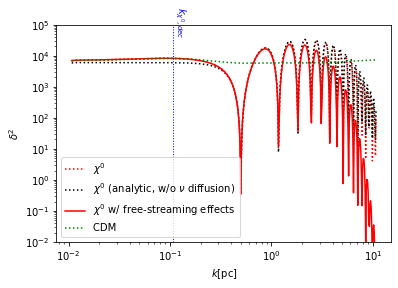

In [39]:
# This is obsolute; 
# to plot absolute value of power spectrum correctly, tau_fin should be the same
# plot power spectrum
#temp_eq = 1e-9 # temperature at equality
#tau_eq = 1/chubble(temp_eq)
wav_fs = math.sqrt(6/5*(temp_dec/mass_wino))\
    *tau_dec*math.log(tau_eq/tau_dec) #special.gamma(3/4) is replaed with 6/5

wav_fs = 1/wav_fs
print('#Free-streaming wave number at equality [pc^-1]]:',wav_fs*pc_GeV)

array_fs_damp = np.empty(num_wav)
for i in range(num_wav):
    array_fs_damp[i] = math.exp(-array_wav[i]**2/wav_fs**2)

plt.xscale('log')
plt.yscale('log')
plt.plot(array_wav*pc_GeV,array_sol[:,idx_delta_chi,num_tau-1]**2,'r:',label=r'$\chi^0$')
plt.plot(array_wav*pc_GeV,array_sol[:,idx_delta_chi_wo_diff,num_tau-1]**2,'k:',label=r'$\chi^0$ (analytic, w/o $\nu$ diffusion)')
plt.plot(array_wav*pc_GeV,array_sol[:,idx_delta_chi,num_tau-1]**2*array_fs_damp,'r',label='$\chi^0$ w/ free-streaming effects')
plt.plot(array_wav*pc_GeV,array_sol[:,idx_delta_cdm,num_tau-1]**2,'g:',label=r'CDM ')


plt.axvline(x=wav_dec*pc_GeV,c='b',ls=':',lw=1)
plt.text(wav_dec*pc_GeV,5e4,r'$k_{\chi^0, dec}$',rotation=-90,color='b')
#plt.axvline(x=wav_nudec*pc_GeV,c='b',ls=':',lw=1)
#plt.text(wav_nudec*pc_GeV,5e4,r'$k_{\nu, dec}$',rotation=-90,color='b')
plt.axis([None,None,1e-2,1e5])
plt.xlabel(r'$k$[pc]')
plt.ylabel(r'$\delta^2$')
plt.legend()
plt.savefig('figures/test/power.pdf')

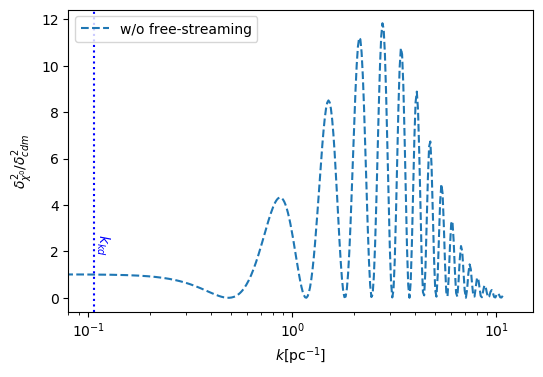

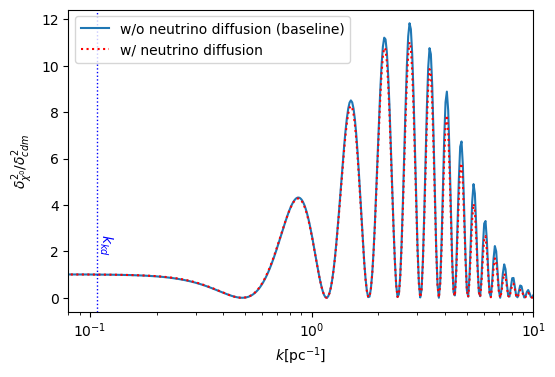

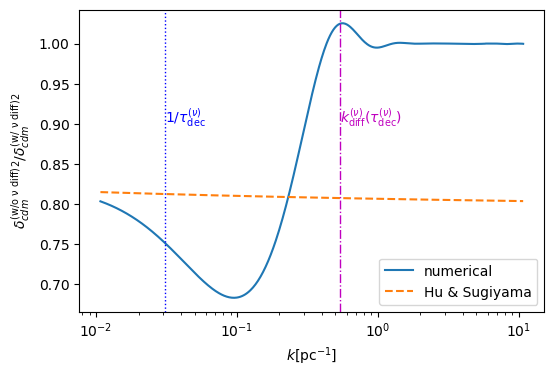

In [113]:
# plot power ratio
from scipy import optimize

array_cdm0 = np.empty(num_wav)
for i in range(num_wav):
    array_cdm0[i] = ideal(array_wav[i],array_tau_fin[i])[idx_delta_cdm]

def fitAK(wav):
    pn=15
    cN=0.91
    cdamp=0.95
    ckd=1.05#1.04
    kkd=ckd/tau_dec
    kdamp=cdamp*pn*math.sqrt(3)/math.pi*kkd
    return cN*4*math.pi/pn*math.exp(-wav/kdamp)*(math.sin(wav/math.sqrt(3)/kkd))**2*(wav/math.sqrt(3)/2/kkd)**3#*(1+1/(cN*4*math.pi/pn*(wav/math.sqrt(3)/kkd)**5/8))
arr_fitAK = np.array([fitAK(wav) for wav in array_wav])

plt.figure(dpi=100)
plt.rcParams["font.size"] = 10
plt.xscale('log')
#plt.plot(array_wav*pc_GeV,array_sol[:,idx_delta_chi,num_tau-1]**2/array_sol[:,idx_delta_cdm,num_tau-1]**2,'k:',label=r'$\chi^0$')
plt.plot(array_wav*pc_GeV,1/array_ratio_wo_diff**2,'--',linewidth=1.5,label=r'w/o free-streaming')
#plt.plot(array_wav*pc_GeV,1/array_ratio_wo_diff**2*array_fs_damp,'-',linewidth=1.5,label=r'w/ free-streaming')

#plt.plot(array_wav*pc_GeV,array_sol[:,idx_delta_chi,num_tau-1]**2/array_sol[:,idx_delta_cdm,num_tau-1]**2*array_fs_damp,'k',label=r'$\chi^0$ w/ free-streaming effects')
#plt.plot(array_wav*pc_GeV,array_sol[:,idx_delta_chi_wo_diff,num_tau-1]**2/array_cdm0**2,'--',color='grey',linewidth=1.5,label=r'w/o free-streaming at $\tau_{\rm end}$')
#plt.plot(array_wav*pc_GeV,array_sol[:,idx_delta_chi_wo_diff,num_tau-1]**2/array_cdm0**2*array_fs_damp,'-',color='black',linewidth=1.5,label=r'w/ free-streaming at $\tau_{\rm end}$')

#plt.plot(array_wav*pc_GeV,arr_fitAyuki,':',linewidth=1.5,label=r'fitting (w/o free-streaming)')
#plt.plot(array_wav*pc_GeV,arr_fitTS,':',linewidth=1.5,label=r'fitting2 (w/o free-streaming)')


plt.axvline(x=wav_dec*pc_GeV,c='b',ls=':',lw=1.5)
plt.text(wav_dec*pc_GeV,2,r'$k_{kd}$',rotation=-90,color='b')
#plt.axvline(x=wav_fs*pc_GeV,c='m',ls='-.',lw=1.5)
#plt.text(wav_fs*pc_GeV,11,r'$k_{fs}$',rotation=-90,color='m')


#plt.axvline(x=wav_nudec*pc_GeV,c='b',ls=':',lw=1)
#plt.text(wav_nudec*pc_GeV,1,r'$k_{\nu, dec}$',rotation=-90,color='b')
plt.axis([0.08,None,None,None])
plt.xlabel(r'$k$[pc$^{-1}$]')
plt.ylabel(r'$\delta_{\chi^0}^2/\delta_{cdm}^2$')
plt.legend()
plt.savefig('figures/test/Pkratio.pdf')

# plot power ratio
plt.figure(dpi=100)
#plt.ylim(1e-4,2e2)
plt.xscale('log')
#plt.yscale('log')
plt.plot(array_wav*pc_GeV,1/array_ratio_wo_diff**2,'-',linewidth=1.5,label=r'w/o neutrino diffusion (baseline)')
plt.plot(array_wav*pc_GeV,1/array_ratio_w_diff**2,'r:',linewidth=1.5,label=r'w/ neutrino diffusion')
#plt.plot(array_wav*pc_GeV,array_sol[:,idx_delta_chi_wo_diff,num_tau-1]**2/array_cdm0**2,'--',color='grey',linewidth=1.5,label=r'w/o neutrino diffusion (baseline) at $\tau_{\rm end}$')
#plt.plot(array_wav*pc_GeV,array_sol[:,idx_delta_chi,num_tau-1]**2/array_sol[:,idx_delta_cdm,num_tau-1]**2,'--',color='cyan',linewidth=1.5,label=r'w/ neutrino diffusion at $\tau_{\rm end}$')
#plt.plot(array_wav*pc_GeV,arr_fitAK,'--',linewidth=1.5,label=r'analytic expression')
#plt.plot(array_wav*pc_GeV,arr_fitTS,'--',linewidth=1.5,label=r'analytic expression 2')
#plt.plot(array_wav*pc_GeV,arr_fitTS,'b-.',linewidth=1.5,label=r'fitting function 2')

plt.axvline(x=wav_dec*pc_GeV,c='b',ls=':',lw=1)
plt.text(wav_dec*pc_GeV,2,r'$k_{kd}$',rotation=-90,color='b')
#plt.axvline(x=wav_nudec*pc_GeV,c='b',ls=':',lw=1)
#plt.text(wav_nudec*pc_GeV,1,r'$k_{\nu, dec}$',rotation=-90,color='b')
plt.axis([0.08,10,None,None])
plt.xlabel(r'$k$[pc$^{-1}$]')
plt.ylabel(r'$\delta_{\chi^0}^2/\delta_{cdm}^2$')
plt.legend()
plt.savefig('figures/test/Pkratio_nudiff.pdf')

def Hu_Sugiyama(wav,fnu):
    Phi0 = (10+4*fnu)/(15+4*fnu)
    I_1 = 9.11*(1+0.128*fnu+0.029*fnu**2)
    I_2 = 0.594*(1-0.631*fnu+0.284*fnu**2)
    aa = wav/keq
    return Phi0*I_1*np.log(I_2*aa)
array_Hu_Sugiyama = np.array([(Hu_Sugiyama(wav,0)/Hu_Sugiyama(wav,fnu))**2 for wav in array_wav])

# plot cdm w/ and w/o neutrino diffusion
plt.figure(dpi=100)
plt.xscale('log')
#plt.plot(array_wav*pc_GeV,array_cdm0**2/array_sol[:,idx_delta_cdm,num_tau-1]**2,label=r'at $\tau_{\rm end}$')
plt.plot(array_wav*pc_GeV,array_ratio_cdm**2,label=r'numerical')
plt.plot(array_wav*pc_GeV,array_Hu_Sugiyama,'--',label=r'Hu & Sugiyama')
plt.axvline(x=wav_nudec*pc_GeV,c='b',ls=':',lw=1)
plt.text(wav_nudec*pc_GeV,0.9,r'$1/\tau^{(\nu)}_{\rm dec}$',color='b')
plt.axvline(x=wav_nudiff*pc_GeV,c='m',ls='-.',lw=1)
plt.text(wav_nudiff*pc_GeV,0.9,r'$k^{(\nu)}_{\rm diff}(\tau^{(\nu)}_{\rm dec})$',color='m')

plt.axis([None,None,None,None])
plt.xlabel(r'$k$[pc$^{-1}$]')
plt.ylabel(r'${\delta_{cdm}^{\rm (w/o\ \nu\ diff)}}^2/{\delta_{cdm}^{\rm (w/\ \nu\ diff)}}^2$')
plt.legend()
plt.savefig('figures/test/Pkratio_nudiff_cdm.pdf')

0.7723810629308724 8.638505951083504 0.5840981834960042
0.7723810629308724 8.638505951083504 0.5840981834960042


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


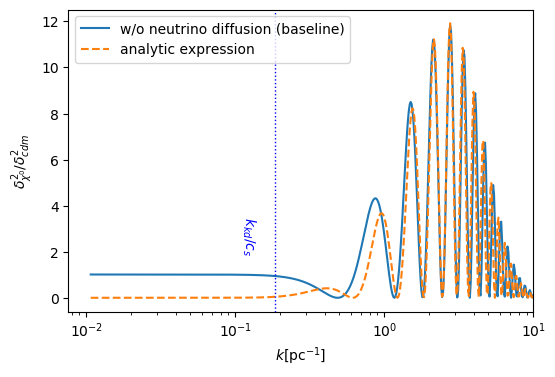

In [114]:
def func_pratio_fit(wav,fit_visib):
    amp = fit_visib[0]*fit_visib[2]*np.sqrt(math.pi/2)
    x0 = wav*fit_visib[1]/np.sqrt(3)
    dx = wav*fit_visib[2]/np.sqrt(3)
#    r = np.exp(-dx**2/2)*((2+dx**2)*np.cos(x0)+x0*np.sin(x0))-2
    r = np.exp(-dx)*(2*(1+dx-dx**2/2)*np.cos(x0)+x0*np.sin(x0))-2
    r *= amp 
    r += 1
    return r**2

#Least squares method with scipy.optimize
def error_func(fit_visib,wav,y):
    return y-func_pratio_fit(wav,fit_visib)

print(fit_visib_opt[0]*pc_GeV,fit_visib_opt[1]/pc_GeV,fit_visib_opt[2]/pc_GeV)
result = optimize.leastsq(error_func,fit_visib_init,args=(array_wav,1/array_ratio_wo_diff**2))
fit_visib_opt=result[0][0:3]
#
fit_visib_opt[0] *= 1
fit_visib_opt[1] *= 1
fit_visib_opt[2] *= 1
#
print(fit_visib_opt[0]*pc_GeV,fit_visib_opt[1]/pc_GeV,fit_visib_opt[2]/pc_GeV)

arr_fitTS = np.array([func_pratio_fit(wav,fit_visib_opt) for wav in array_wav])

plt.figure(dpi=100)
#plt.ylim(1e-4,2e2)
plt.xscale('log')
plt.plot(array_wav*pc_GeV,1/array_ratio_wo_diff**2,'-',linewidth=1.5,label=r'w/o neutrino diffusion (baseline)')
plt.plot(array_wav*pc_GeV,arr_fitAK,'--',linewidth=1.5,label=r'analytic expression')
#plt.plot(array_wav*pc_GeV,arr_fitTS,'--',linewidth=1.5,label=r'analytic expression 2')

plt.axvline(x=wav_dec*pc_GeV/soundv,c='b',ls=':',lw=1)
plt.text(wav_dec*pc_GeV,2,r'$k_{kd}/c_s$',rotation=-90,color='b')
plt.axis([0,10,None,None])
plt.xlabel(r'$k$[pc$^{-1}$]')
plt.ylabel(r'$\delta_{\chi^0}^2/\delta_{cdm}^2$')
plt.legend()
plt.savefig('figures/test/Pkratio_fit.pdf')



In [89]:
##### from scipy import integrate

alpha_pk = 1-0.328*math.log(431*omh2)*obh2/omh2+0.38*math.log(22.3*omh2)*(obh2/omh2)**2
delta_cr = 1.69 # critical overdensity
fourpi = 4*math.pi
twopi2 = 2*math.pi**2

array_Pkratio = 1/array_ratio_wo_diff**2*array_fs_damp 
#array_sol[:,idx_delta_chi,num_tau-1]**2/array_sol[:,idx_delta_cdm,num_tau-1]**2*array_fs_damp
interp_Pkratio = interpolate.interp1d(array_wav,array_Pkratio)

def Pkratio(k):
    if(k<wav_dec):
        return 1
    elif(k>array_wav[num_wav-1]):
        return 0
    else:
        return interp_Pkratio(k)
        
def Msub2Rsub(Msub):
    return (Msub/rhodm0*3/fourpi)**(third)

def Rsub2Msub(Rsub):
    return fourpi/3*rhodm0*Rsub**3

def primPk(k):
    return twopi2/k**3*As*(k/kpiv)**(ns-1)

def growthf(a):
    x = OLambda/OMatter*a**3
    return a*5/6*x**(-5/6)*math.sqrt(1+x)\
        *integrate.quad(lambda x:1/x**(1/6)/(1+x)**(3/2),0,x)[0]

def PkcdmA(k,a): # analytic
    kappa = math.sqrt(2)*k/keq/alpha_pk
    Tk = 45/2/kappa**2*(-7/2+gamma_eular+math.log(4*kappa/math.sqrt(3)))
    D = growthf(a)
    return (2/5*Tk*(k/H0h)**2*D/omh2)**2*primPk(k)

Mpc_GeV_invh = Mpc_GeV/redh

###
PkC = np.loadtxt('test_planck_matterpower_1e7.dat')
num_PkC = np.shape(PkC)[0]
lnPkAC = np.empty(num_PkC)
#for i in range(num_PkC):
#    lnPkAC[i] = math.log(PkC[i,1]*(Mpc_GeV_invh)**3/PkcdmA(PkC[i,0]/Mpc_GeV_invh,1))

interp_lnPkAC = interpolate.interp1d(np.log(PkC[:,0]/Mpc_GeV_invh),np.log(PkC[:,1]*(Mpc_GeV_invh)**3),fill_value="extrapolate")

def PkcdmC(k,a): # CAMB or CLASS
    lnk = math.log(k)
    #return PkcdmA(k,a)*math.exp(interp_lnPkAC(lnk))
    return math.exp(interp_lnPkAC(lnk))

def Pkchi(k,a):
    return PkcdmC(k,a)*Pkratio(k)


def windowfSk(k,Rsub):
    hatb = 4.8
    hatc = 3.3
    R = Rsub/hatc
    w = 1/(1+(k*R)**hatb)
    return [w,-hatb/3*(1-w)*w]

def windowfTH(k,Rsub):
    x = k*Rsub
    if(x>1e-3):
        w = 3*(math.sin(x)-x*math.cos(x))/(x**3)
        dw = math.sin(x)/x-w
    else:
        x2 = x*x
        w = 1-x2/10+x2*x2/280-x2*x2*x2/15120
        dw = -x2/15+x2*x2/210-x2*x2*x2/7560
    return [w,dw]

num_Msub = 200
Msub_max = 1e15*Msun
Rsub_max = Msub2Rsub(Msub_max)
#Rsub_min = 0.3/wav_fs
#Msub_min = Rsub2Msub(Rsub_min)
Msub_min = Msun*1e-15
Msubs = np.logspace(math.log10(Msub_min),math.log10(Msub_max),num_Msub,base=10)
nu2CDM = np.empty([num_Msub,2])
nu2chi = np.empty([num_Msub,2])
nu2CDMT = np.empty([num_Msub,2])
nu2chiT = np.empty([num_Msub,2])

for i in range(num_Msub):
    Rsub = Msub2Rsub(Msubs[i])
#    kmax = 10/Rsub
#    kmin = min(0.01/Rsub,0.1*keq)
    kmaxCDM = 10/Rsub
    kminCDM = 0.01*kmaxCDM
    lnkmaxCDM = math.log(kminCDM)
    lnkminCDM = math.log(min(0.01*kminCDM,0.001*keq))
    kmaxchi = min(20/Rsub,7*wav_fs)
    kminchi = 0.01*kmaxchi
    lnkmaxchi = math.log(kminchi)
    lnkminchi = math.log(min(0.01*kminchi,0.001*keq))
    
    # CDM
    sigma2 = integrate.quad(lambda x:math.exp(3*x)/twopi2*PkcdmC(math.exp(x),1)*windowfSk(math.exp(x),Rsub)[0]**2,lnkminCDM,lnkmaxCDM,limit=200)[0]
    dsigma2dlnM_2 = integrate.quad(lambda x:math.exp(3*x)/twopi2*PkcdmC(math.exp(x),1)*windowfSk(math.exp(x),Rsub)[0]*windowfSk(math.exp(x),Rsub)[1],lnkminCDM,lnkmaxCDM,limit=200)[0]
    sigma2 += integrate.quad(lambda k:k**2/twopi2*PkcdmC(k,1)*windowfSk(k,Rsub)[0]**2,kminCDM,kmaxCDM,limit=200)[0]
    dsigma2dlnM_2 += integrate.quad(lambda k:k**2/twopi2*PkcdmC(k,1)*windowfSk(k,Rsub)[0]*windowfSk(k,Rsub)[1],kminCDM,kmaxCDM,limit=200)[0]
    nu2CDM[i,0] = delta_cr**2/sigma2
    nu2CDM[i,1] = -dsigma2dlnM_2/sigma2
    # wino
    sigma2 = integrate.quad(lambda x:math.exp(3*x)/twopi2*Pkchi(math.exp(x),1)*windowfSk(math.exp(x),Rsub)[0]**2,lnkminchi,lnkmaxchi,limit=200)[0]
    dsigma2dlnM_2 = integrate.quad(lambda x:math.exp(3*x)/twopi2*Pkchi(math.exp(x),1)*windowfSk(math.exp(x),Rsub)[0]*windowfSk(math.exp(x),Rsub)[1],lnkminchi,lnkmaxchi,limit=200)[0]
    sigma2 += integrate.quad(lambda k:k**2/twopi2*Pkchi(k,1)*windowfSk(k,Rsub)[0]**2,kminchi,kmaxchi,limit=200)[0]
    dsigma2dlnM_2 += integrate.quad(lambda k:k**2/twopi2*Pkchi(k,1)*windowfSk(k,Rsub)[0]*windowfSk(k,Rsub)[1],kminchi,kmaxchi,limit=200)[0]
    nu2chi[i,0] = delta_cr**2/sigma2
    nu2chi[i,1] = -dsigma2dlnM_2/sigma2

    # CDM
    sigma2 = integrate.quad(lambda x:math.exp(3*x)/twopi2*PkcdmC(math.exp(x),1)*windowfTH(math.exp(x),Rsub)[0]**2,lnkminCDM,lnkmaxCDM,limit=200)[0]
    dsigma2dlnM_2 = integrate.quad(lambda x:math.exp(3*x)/twopi2*PkcdmC(math.exp(x),1)*windowfTH(math.exp(x),Rsub)[0]*windowfTH(math.exp(x),Rsub)[1],lnkminCDM,lnkmaxCDM,limit=200)[0]
    sigma2 += integrate.quad(lambda k:k**2/twopi2*PkcdmC(k,1)*windowfTH(k,Rsub)[0]**2,kminCDM,kmaxCDM,limit=200)[0]
    dsigma2dlnM_2 += integrate.quad(lambda k:k**2/twopi2*PkcdmC(k,1)*windowfTH(k,Rsub)[0]*windowfTH(k,Rsub)[1],kminCDM,kmaxCDM,limit=200)[0]
    nu2CDMT[i,0] = delta_cr**2/sigma2
    nu2CDMT[i,1] = -dsigma2dlnM_2/sigma2
    # wino
    sigma2 = integrate.quad(lambda x:math.exp(3*x)/twopi2*Pkchi(math.exp(x),1)*windowfTH(math.exp(x),Rsub)[0]**2,lnkminchi,lnkmaxchi,limit=200)[0]
    dsigma2dlnM_2 = integrate.quad(lambda x:math.exp(3*x)/twopi2*Pkchi(math.exp(x),1)*windowfTH(math.exp(x),Rsub)[0]*windowfTH(math.exp(x),Rsub)[1],lnkminchi,lnkmaxchi,limit=200)[0]
    sigma2 += integrate.quad(lambda k:k**2/twopi2*Pkchi(k,1)*windowfTH(k,Rsub)[0]**2,kminchi,kmaxchi,limit=200)[0]
    dsigma2dlnM_2 += integrate.quad(lambda k:k**2/twopi2*Pkchi(k,1)*windowfTH(k,Rsub)[0]*windowfTH(k,Rsub)[1],kminchi,kmaxchi,limit=200)[0]
    nu2chiT[i,0] = delta_cr**2/sigma2
    nu2chiT[i,1] = -dsigma2dlnM_2/sigma2
        
def multiplicity(nu2):
    A = 0.3222
    p = 0.3
    q = 1
    qnu2 = q*nu2
    return A*math.sqrt(2*qnu2/math.pi)*(1+(qnu2)**(-p))*math.exp(-qnu2/2)

def multiplicityT(nu2):
    A = 0.3222
    p = 0.3
    q = 0.707
    qnu2 = q*nu2
    return A*math.sqrt(2*qnu2/math.pi)*(1+(qnu2)**(-p))*math.exp(-qnu2/2)

##
ttt = interpolate.splrep(np.log(Msubs/Msun),np.log(delta_cr/np.sqrt(nu2CDM[:,0])),s=0)
sss = interpolate.splev(np.log(Msubs/Msun),ttt,der=1)
arr_sigmaM = np.stack((Msubs/Msun,delta_cr/np.sqrt(nu2CDM[:,0]),-nu2CDM[:,1],sss),axis=-1)
np.savetxt('./sigmaM_cdm_smoothk.txt',arr_sigmaM)
ttt = interpolate.splrep(np.log(Msubs/Msun),np.log(delta_cr/np.sqrt(nu2CDMT[:,0])),s=0)
sss = interpolate.splev(np.log(Msubs/Msun),ttt,der=1)
arr_sigmaM = np.stack((Msubs/Msun,delta_cr/np.sqrt(nu2CDMT[:,0]),-nu2CDMT[:,1],sss),axis=-1)
np.savetxt('./sigmaM_cdm_tophat.txt',arr_sigmaM)
#
ttt = interpolate.splrep(np.log(Msubs/Msun),np.log(delta_cr/np.sqrt(nu2chi[:,0])),s=0)
sss = interpolate.splev(np.log(Msubs/Msun),ttt,der=1)
arr_sigmaM = np.stack((Msubs/Msun,delta_cr/np.sqrt(nu2chi[:,0]),-nu2chi[:,1],sss),axis=-1)
np.savetxt('./sigmaM_chi_smoothk.txt',arr_sigmaM)
ttt = interpolate.splrep(np.log(Msubs/Msun),np.log(delta_cr/np.sqrt(nu2chiT[:,0])),s=0)
sss = interpolate.splev(np.log(Msubs/Msun),ttt,der=1)
arr_sigmaM = np.stack((Msubs/Msun,delta_cr/np.sqrt(nu2chiT[:,0]),-nu2chiT[:,1],sss),axis=-1)
np.savetxt('./sigmaM_chi_tophat.txt',arr_sigmaM)
##

print('# compute ratio of chi to CDM in mass functions')

massf_ratio = np.empty(num_Msub)
massf_ratioT = np.empty(num_Msub)
for i in range(num_Msub):
    massf_ratio[i] = multiplicity(nu2chi[i,0])/multiplicity(nu2CDM[i,0])\
        *nu2chi[i,1]/nu2CDM[i,1]
    massf_ratioT[i] = multiplicityT(nu2chiT[i,0])/multiplicityT(nu2CDMT[i,0])\
        *nu2chiT[i,1]/nu2CDMT[i,1]
    print(Msubs[i],massf_ratio[i],massf_ratioT[i])
    

/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


# compute ratio of chi to CDM in mass functions
1.1154108755999955e+42 2.898360571582922e-12 4.676228631019556e-05
1.5782966820378642e+42 4.992475492868655e-12 5.8255635010348894e-05
2.2332760698534667e+42 8.598481208198027e-12 7.264892220253038e-05
3.1600662036115277e+42 1.4822585434135482e-11 9.048906528280636e-05
4.471466177427476e+42 2.5555223166584988e-11 0.00011282611813334689
6.327085727832889e+42 4.4043488779406035e-11 0.0001405863134026047
8.952771243005993e+42 7.589847701035831e-11 0.00017515993785930186
1.266809339677614e+43 1.3078968506005927e-10 0.00021821546025720185
1.7925241911526546e+43 2.2534540305082972e-10 0.00027182815765413405
2.5364061309219426e+43 3.8823054355257533e-10 0.00033858015047349234
3.588992602014289e+43 6.687941787704191e-10 0.0004214423138037722
5.078393298407263e+43 1.151993248092009e-09 0.0005251255509139445
7.185882322196421e+43 1.9841314367864137e-09 0.000653877622226346
1.0167960950296835e+44 3.3143891532445886e-09 0.0008141109293044316
1.438757

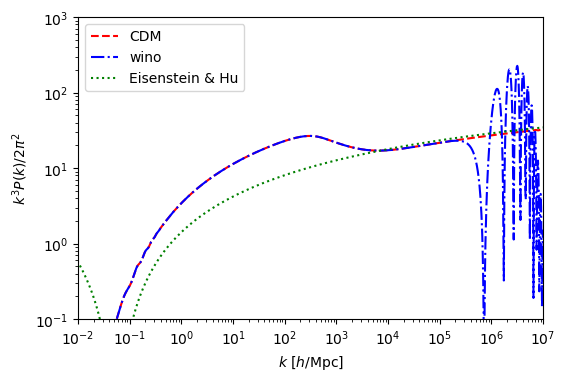

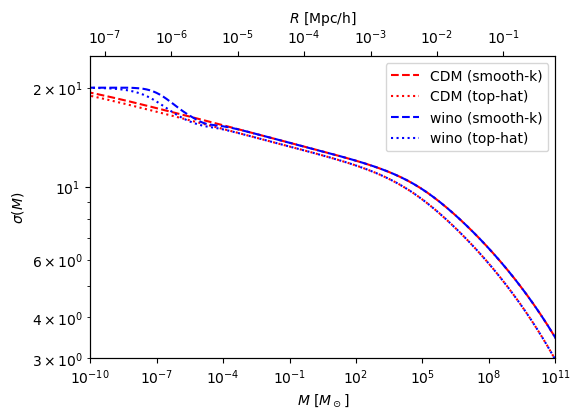

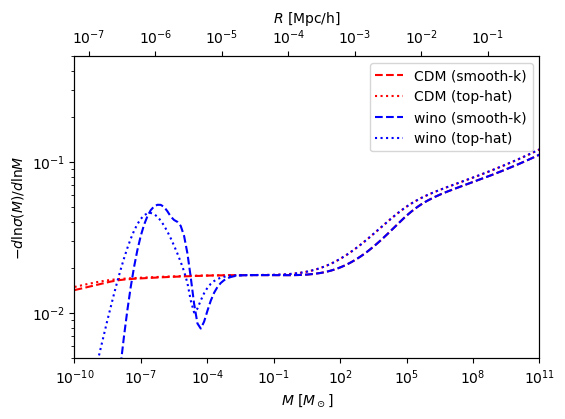

In [90]:
###
plt.figure(dpi=100)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [$h$/Mpc]')
plt.ylabel(r'$k^3P(k)/2\pi^2$')
plt.xlim([1e-2,1e7])
plt.ylim([1e-1,1e3])
#plt.plot(PkC[:,0],PkC[:,0]**3/twopi2*PkC[:,1],'k-',label='CDM')
plt.plot(PkC[:,0],np.array([PkC[i,0]**3/twopi2*PkcdmC(PkC[i,0]/Mpc_GeV_invh,1)/(Mpc_GeV_invh)**3 for i in range(num_PkC)]),'r--',label='CDM')
plt.plot(PkC[:,0],np.array([PkC[i,0]**3/twopi2*Pkchi(PkC[i,0]/Mpc_GeV_invh,1)/(Mpc_GeV_invh)**3 for i in range(num_PkC)]),'b-.',label='wino')
plt.plot(PkC[:,0],np.array([PkC[i,0]**3/twopi2*PkcdmA(PkC[i,0]/Mpc_GeV_invh,1)/(Mpc_GeV_invh)**3 for i in range(num_PkC)]),'g:',label='Eisenstein & Hu')
plt.legend()
plt.savefig('k3Pk.pdf')
###


###
fig = plt.figure(dpi=100)
ax1 = fig.add_subplot(111)
ax1.set_xlabel(r'$M$ [$M_\odot$]')
ax1.set_ylabel(r'$\sigma(M)$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([1e-10,1e11])
ax1.set_ylim([3,25])
ax1.plot(Msubs/Msun,delta_cr/np.sqrt(nu2CDM[:,0]),'r--',label='CDM (smooth-k)')
ax1.plot(Msubs/Msun,delta_cr/np.sqrt(nu2CDMT[:,0]),'r:',label='CDM (top-hat)')
ax1.plot(Msubs/Msun,delta_cr/np.sqrt(nu2chi[:,0]),'b--',label='wino (smooth-k)')
ax1.plot(Msubs/Msun,delta_cr/np.sqrt(nu2chiT[:,0]),'b:',label='wino (top-hat)')
ax1.legend()
#
ax2 = ax1.twiny()
ax2.set_xscale('log')
newlabel = np.array([1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])# labels of the xticklabels: the position in the new x-axis
newpos = np.array([Rsub2Msub(R*Mpc_GeV/redh)/Msun for R in newlabel])   # position of the xticklabels in the old x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels([r"$10^{{ {:2d} }}$".format(int(ep)) for ep in np.log10(newlabel)])
ax2.set_xlabel(r'$R$ [Mpc/h]')
ax2.set_xlim(ax1.get_xlim())
#
fig.savefig('sigmaM.pdf')
###

###
fig = plt.figure(dpi=100)
ax1 = fig.add_subplot(111)
ax1.set_xlabel(r'$M$ [$M_\odot$]')
ax1.set_ylabel(r'$-d\ln\sigma(M)/d\ln M$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([1e-10,1e11])
ax1.set_ylim([5e-3,5e-1])
ax1.plot(Msubs/Msun,nu2CDM[:,1],'r--',label='CDM (smooth-k)')
ax1.plot(Msubs/Msun,nu2CDMT[:,1],'r:',label='CDM (top-hat)')
ax1.plot(Msubs/Msun,nu2chi[:,1],'b--',label='wino (smooth-k)')
ax1.plot(Msubs/Msun,nu2chiT[:,1],'b:',label='wino (top-hat)')
ax1.legend()
#
ax2 = ax1.twiny()
ax2.set_xscale('log')
newlabel = np.array([1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])# labels of the xticklabels: the position in the new x-axis
newpos = np.array([Rsub2Msub(R*Mpc_GeV/redh)/Msun for R in newlabel])   # position of the xticklabels in the old x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels([r"$10^{{ {:2d} }}$".format(int(ep)) for ep in np.log10(newlabel)])
ax2.set_xlabel(r'$R$ [Mpc/h]')
ax2.set_xlim(ax1.get_xlim())
#
fig.savefig('dlnsigmaM_dlnM.pdf')
###

1e-15


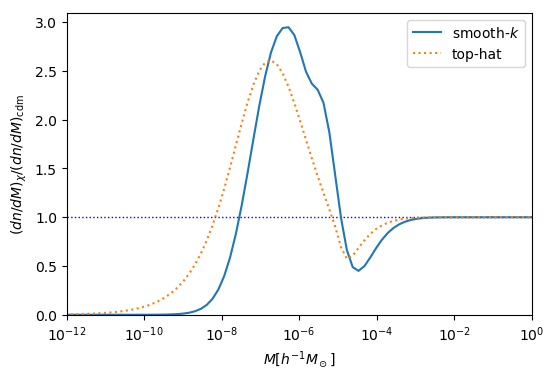

In [91]:
print(Msub_min/Msun)
# plot massf ratio
plt.figure(dpi=100)
plt.xscale('log')
plt.axhline(y=1,c='b',ls=':',lw=1)
plt.plot(Msubs*redh/Msun,massf_ratio,'-',label=r'smooth-$k$')
plt.plot(Msubs*redh/Msun,massf_ratioT,':',label=r'top-hat')
plt.xlabel(r'$M$[$h^{-1}M_\odot$]')
plt.ylabel(r'$(dn/dM)_{\chi}/(dn/dM)_{\rm cdm}$')
plt.axis([1e-12,1e0,0,None])
plt.legend()
plt.savefig('figures/test/mfratio.pdf')

In [92]:
nparamc = 6
paramc = np.array([37.5153,-1.5093,1.636e-2,3.66e-4,-2.89237e-5,5.32e-7])

filterf = 1 # smooth-k if 1; top-hat if 2

Mmina = 1e-11*Msun
Mminb = Rsub2Msub(tau_dec)
Mminc = Rsub2Msub(math.pi/wav_fs)
print(Mmina/Msun,Mminb/Msun,Mminc/Msun)

# switching off boost factor in the subhalos
fsubhalo = 1.e0
print('# fsubhalo =',fsubhalo)

def concentration1(M): # Sanchez-Conde
    x = math.log(M*redh/Msun)
    ax = np.array([x**i for i in range(nparamc)])
    return sum(ax*paramc)
#def concentration2(M): # Neto
#    return 5.26*(M*redh/1e14/Msun)**-0.10
def concentration3(M): # Prada
    return 7.80*(M*redh/1e12/Msun)**-0.08*(1+0.2*math.sqrt(M*redh/1e15/Msun))

def fc(c):
    return math.log(1+c)-c/(1+c)

def LofM1(Msub):
    c = concentration1(Msub)
    f = fc(c)
    return fourpi*Msub*c**3/f**2
#def LofM2(Msub):
#    c = concentration2(Msub)
#    f = fc(c)
#    return fourpi*Msub*c**3/f**2
def LofM3(Msub):
    c = concentration3(Msub)
    f = fc(c)
    return fourpi*Msub*c**3/f**2

Ami = 0.0318#0.03
alphami = 1.9
betami = 1-alphami
Amro = 0.0145#0.012
alphamro = 2
betamro = 1-alphamro

if(filterf==1):
    interp_massf_ratio = interpolate.interp1d(Msubs,massf_ratio,fill_value="extrapolate")
elif(filterf==2):
    interp_massf_ratio = interpolate.interp1d(Msubs,massf_ratioT,fill_value="extrapolate")

BofM = np.zeros(num_Msub)
BofM1i = np.zeros(num_Msub)
BofM2i = np.zeros(num_Msub)
BofM3i = np.zeros(num_Msub)
BofM1ro = np.zeros(num_Msub)
BofM2ro = np.zeros(num_Msub)
BofM3ro = np.zeros(num_Msub)
BofM1ib = np.zeros(num_Msub)
BofM2ib = np.zeros(num_Msub)
BofM3ib = np.zeros(num_Msub)
BofM1rob = np.zeros(num_Msub)
BofM2rob = np.zeros(num_Msub)
BofM3rob = np.zeros(num_Msub)

def dBLMdlnM1i(lnM,BLM):
    M = Msubs[0]*math.exp(lnM)
    return Ami*(LofM1(M)*math.exp(betami*lnM)+fsubhalo*BLM[:])*interp_massf_ratio(M)

#def dBLMdlnM2i(lnM,BLM):
#    M = Msubs[0]*math.exp(lnM)
#    return Ami*(LofM2(M)*math.exp(betami*lnM)+fsubhalo*BLM[:])*interp_massf_ratio(M)

def dBLMdlnM3i(lnM,BLM):
    M = Msubs[0]*math.exp(lnM)
    return Ami*(LofM3(M)*math.exp(betami*lnM)+fsubhalo*BLM[:])*interp_massf_ratio(M)

def dBLMdlnM1ro(lnM,BLM):
    M = Msubs[0]*math.exp(lnM)
    return Amro*(LofM1(M)*math.exp(betamro*lnM)+fsubhalo*BLM[:])*interp_massf_ratio(M)

#def dBLMdlnM2ro(lnM,BLM):
#    M = Msubs[0]*math.exp(lnM)
#    print(lnM)
#    return Amro*(LofM2(M)*math.exp(betamro*lnM)+fsubhalo*BLM[:])*interp_massf_ratio(M)

def dBLMdlnM3ro(lnM,BLM):
    M = Msubs[0]*math.exp(lnM)
    return Amro*(LofM3(M)*math.exp(betamro*lnM)+fsubhalo*BLM[:])*interp_massf_ratio(M)

def dBLMdlnM1i0(lnM,BLM):
    M = Msubs[0]*math.exp(lnM)
    return Ami*(LofM1(M)*math.exp(betami*lnM)+fsubhalo*BLM[:])

#def dBLMdlnM2i0(lnM,BLM):
#    M = Msubs[0]*math.exp(lnM)
#    return Ami*(LofM2(M)*math.exp(betami*lnM)+fsubhalo*BLM[:])

def dBLMdlnM3i0(lnM,BLM):
    M = Msubs[0]*math.exp(lnM)
    return Ami*(LofM3(M)*math.exp(betami*lnM)+fsubhalo*BLM[:])

def dBLMdlnM1ro0(lnM,BLM):
    M = Msubs[0]*math.exp(lnM)
    return Amro*(LofM1(M)*math.exp(betamro*lnM)+fsubhalo*BLM[:])

#def dBLMdlnM2ro0(lnM,BLM):
#    M = Msubs[0]*math.exp(lnM)
#    return Amro*(LofM2(M)*math.exp(betamro*lnM)+fsubhalo*BLM[:])

def dBLMdlnM3ro0(lnM,BLM):
    M = Msubs[0]*math.exp(lnM)
    return Amro*(LofM3(M)*math.exp(betamro*lnM)+fsubhalo*BLM[:])

M0 = Msubs[0]
for i in range(1,num_Msub):
    M0 = Msubs[0]
    M1 = Msubs[i-1]
    M2 = Msubs[i]
    t1 = math.log(M1/M0)
    t2 = math.log(M2/M0)
    
    v1 = np.array([BofM1i[i-1]*LofM1(M1)*math.exp(betami*t1)])
    sol = integrate.solve_ivp(dBLMdlnM1i,[t1,t2],v1)
    v2 = sol.y[:,sol.t.size-1]
    BofM1i[i] = v2[0]/LofM1(M2)/math.exp(betami*t2)

    v1 = np.array([BofM1ro[i-1]*LofM1(M1)*math.exp(betamro*t1)])
    sol = integrate.solve_ivp(dBLMdlnM1ro,[t1,t2],v1)
    v2 = sol.y[:,sol.t.size-1]
    BofM1ro[i] = v2[0]/LofM1(M2)/math.exp(betamro*t2)

#    v1 = np.array([BofM2i[i-1]*LofM2(M1)*math.exp(betami*t1)])
#    sol = integrate.solve_ivp(dBLMdlnM2i,[t1,t2],v1)
#    v2 = sol.y[:,sol.t.size-1]
#    BofM2i[i] = v2[0]/LofM2(M2)/math.exp(betami*t2)

#    v1 = np.array([BofM2ro[i-1]*LofM2(M1)*math.exp(betamro*t1)])
#    sol = integrate.solve_ivp(dBLMdlnM2ro,[t1,t2],v1,max_step=1000)
#    v2 = sol.y[:,sol.t.size-1]
#    BofM2ro[i] = v2[0]/LofM2(M2)/math.exp(betamro*t2)

    v1 = np.array([BofM3i[i-1]*LofM3(M1)*math.exp(betami*t1)])
    sol = integrate.solve_ivp(dBLMdlnM3i,[t1,t2],v1)
    v2 = sol.y[:,sol.t.size-1]
    BofM3i[i] = v2[0]/LofM3(M2)/math.exp(betami*t2)

    v1 = np.array([BofM3ro[i-1]*LofM3(M1)*math.exp(betamro*t1)])
    sol = integrate.solve_ivp(dBLMdlnM3ro,[t1,t2],v1)
    v2 = sol.y[:,sol.t.size-1]
    BofM3ro[i] = v2[0]/LofM3(M2)/math.exp(betamro*t2)
    
    if(M2>Mminb):
        v1 = np.array([BofM1ib[i-1]*LofM1(M1)*math.exp(betami*t1)])
        sol = integrate.solve_ivp(dBLMdlnM1i0,[t1,t2],v1)
        v2 = sol.y[:,sol.t.size-1]
        BofM1ib[i] = v2[0]/LofM1(M2)/math.exp(betami*t2)

        v1 = np.array([BofM1rob[i-1]*LofM1(M1)*math.exp(betamro*t1)])
        sol = integrate.solve_ivp(dBLMdlnM1ro0,[t1,t2],v1)
        v2 = sol.y[:,sol.t.size-1]
        BofM1rob[i] = v2[0]/LofM1(M2)/math.exp(betamro*t2)

#        v1 = np.array([BofM2ib[i-1]*LofM2(M1)*math.exp(betami*t1)])
#        sol = integrate.solve_ivp(dBLMdlnM2i0,[t1,t2],v1)
#        v2 = sol.y[:,sol.t.size-1]
#        BofM2ib[i] = v2[0]/LofM2(M2)/math.exp(betami*t2)

#        v1 = np.array([BofM2rob[i-1]*LofM2(M1)*math.exp(betamro*t1)])
#        sol = integrate.solve_ivp(dBLMdlnM2ro0,[t1,t2],v1)
#        v2 = sol.y[:,sol.t.size-1]
#        BofM2rob[i] = v2[0]/LofM2(M2)/math.exp(betamro*t2)

        v1 = np.array([BofM3ib[i-1]*LofM3(M1)*math.exp(betami*t1)])
        sol = integrate.solve_ivp(dBLMdlnM3i0,[t1,t2],v1)
        v2 = sol.y[:,sol.t.size-1]
        BofM3ib[i] = v2[0]/LofM3(M2)/math.exp(betami*t2)

        v1 = np.array([BofM3rob[i-1]*LofM3(M1)*math.exp(betamro*t1)])
        sol = integrate.solve_ivp(dBLMdlnM3ro0,[t1,t2],v1)
        v2 = sol.y[:,sol.t.size-1]
        BofM3rob[i] = v2[0]/LofM3(M2)/math.exp(betamro*t2)    

print(BofM1i[num_Msub-1]/BofM1ib[num_Msub-1])
print(BofM1ro[num_Msub-1]/BofM1rob[num_Msub-1])
print(BofM3i[num_Msub-1]/BofM3ib[num_Msub-1])
print(BofM3ro[num_Msub-1]/BofM3rob[num_Msub-1])

1e-11 0.00011281606631876873 1.086782311610295e-07
# fsubhalo = 1.0


/anaconda3/lib/python3.6/site-packages/scipy/integrate/_ivp/rk.py:145: RuntimeWarning: divide by zero encountered in double_scalars
  max(1, SAFETY * error_norm ** (-1 / (order + 1))))


1.6219707649433757
3.360398446421288
5.164266807319559
11.440433649065854


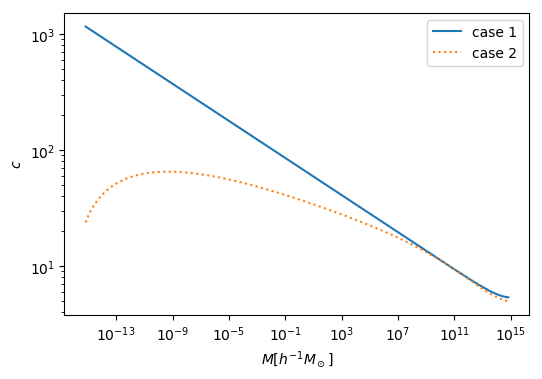

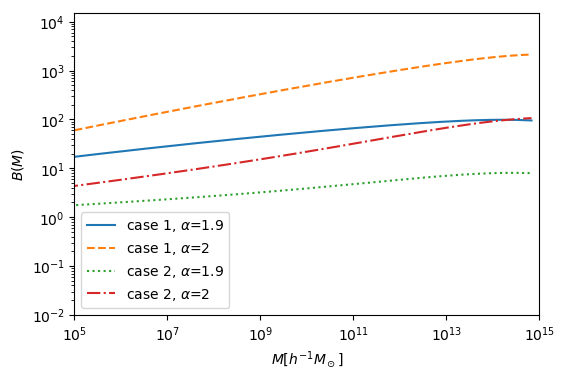

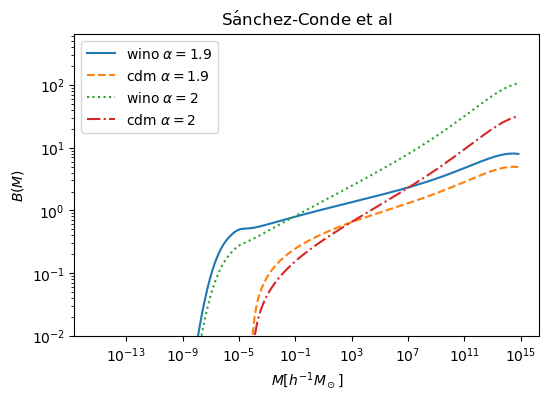

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


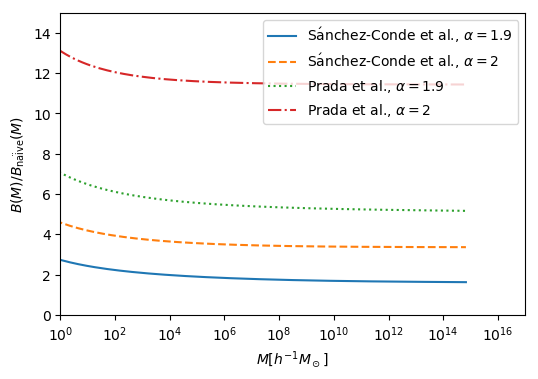

In [93]:
cM1 = np.empty(num_Msub)
#cM2 = np.empty(num_Msub)
cM3 = np.empty(num_Msub)
for i in range(num_Msub):
    cM1[i] = concentration1(Msubs[i])
    #cM2[i] = concentration2(Msubs[i])
    cM3[i] = concentration3(Msubs[i])

plt.figure(dpi=100)
plt.xscale('log')
plt.yscale('log')
plt.plot(Msubs*redh/Msun,cM3,'-',label=r'case 1')
plt.plot(Msubs*redh/Msun,cM1,':',label=r'case 2')
plt.xlabel(r'$M$[$h^{-1}M_\odot$]')
plt.ylabel(r'$c$')
plt.legend()
#plt.axis([1e5,1e15,1e-2,None])
plt.savefig("figures/test/cM.pdf")
plt.show()

plt.figure(dpi=100)
plt.xscale('log')
plt.yscale('log')
#plt.plot(Msubs/Msun,BofM2i,':',label=r'Neto et el., $\alpha$=1.9')
#plt.plot(Msubs/Msun,BofM2ro,'-.',label=r'Neto et el., $\alpha$=2')
plt.plot(Msubs*redh/Msun,BofM3i,'-',label=r'case 1, $\alpha$=1.9')
plt.plot(Msubs*redh/Msun,BofM3ro,'--',label=r'case 1, $\alpha$=2')
plt.plot(Msubs*redh/Msun,BofM1i,':',label=r'case 2, $\alpha$=1.9')
plt.plot(Msubs*redh/Msun,BofM1ro,'-.',label=r'case 2, $\alpha$=2')
plt.xlabel(r'$M$[$h^{-1}M_\odot$]')
plt.ylabel(r'$B(M)$')
plt.legend()
plt.axis([1e5,1e15,1e-2,None])
plt.savefig("figures/test/boost.pdf")
plt.show()

plt.figure(dpi=100)
plt.xscale('log')
plt.yscale('log')
plt.plot(Msubs*redh/Msun,BofM1i,'-',label=r'wino $\alpha=1.9$')
plt.plot(Msubs*redh/Msun,BofM1ib,'--',label=r'cdm $\alpha=1.9$')
plt.plot(Msubs*redh/Msun,BofM1ro,':',label=r'wino $\alpha=2$')
plt.plot(Msubs*redh/Msun,BofM1rob,'-.',label=r'cdm $\alpha=2$')
plt.xlabel(r'$M$[$h^{-1}M_\odot$]')
plt.ylabel(r'$B(M)$')
plt.title(r'S${\rm \'a}$nchez-Conde et al')
plt.legend()
plt.axis([None,None,1e-2,None])
plt.show()

plt.figure(dpi=100)
plt.xscale('log')
plt.plot(Msubs*redh/Msun,BofM1i/BofM1ib,'-',label=r'S${\rm \'a}$nchez-Conde et al., $\alpha=1.9$')
plt.plot(Msubs*redh/Msun,BofM1ro/BofM1rob,'--',label=r'S${\rm \'a}$nchez-Conde et al., $\alpha=2$')
plt.plot(Msubs*redh/Msun,BofM3i/BofM3ib,':',label=r'Prada et al., $\alpha=1.9$')
plt.plot(Msubs*redh/Msun,BofM3ro/BofM3rob,'-.',label=r'Prada et al., $\alpha=2$')
plt.xlabel(r'$M$[$h^{-1}M_\odot$]')
plt.ylabel(r'$B(M)/B_{\rm na\"ive}(M)$')
plt.legend()
plt.axis([1e0,1e17,0,15])
plt.show()
